# Polarimetro de matriz de Jones

La idea es encontrar las posiciones en las que hay que colocar los polarizadores y retardadores para haciendo un numero muy bajo de medidas obtener la matriz de Mueller del sistema. Para ello hay que encontrar los ángulos y hacer las medidas.

## Historial de versiones

**Jones_matrix_polarimeter**

* Planteamiento inicial.

**Jones_matrix_polarimeter_v2**

* Zanjar el tema del criterio de signos del ángulo de retardancia en retardadores.
* Diseñar el método alternativo que incluye más medidas y es más preciso.
* Comprobar que el método funciona para todos los ángulos que digo.
* Pasar los ángulos establecidos a estados (vector de Jones) y viceversa.
* Reproducir la calibraciond e Moreno.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import optimize
import sympy as sy
sy.init_printing(use_unicode=True)
import matplotlib.pyplot as plt
from copy import deepcopy

from py_pol.jones_matrix import Jones_matrix, create_Jones_matrices, degrees
from py_pol.jones_vector import Jones_vector, create_Jones_vectors
from py_pol.utils import charac_angles_2_azimuth_elipt, azimuth_elipt_2_charac_angles, which_quad

## Signo del ángulo de retardancia

Aquí voy a poner lo que dice cada uno sobre el criterio de signos del ángulo de retardancia.

"Polarized light and the Mueller matrix approach", Gil:

$R=\left[\begin{array}{cc}
e^{i\Delta/2} & 0\\
0 & e^{-i\Delta/2}
\end{array}\right]$, X el eje rápido.

"Polarized light and optical systems", Chipman:

Explica que estan los dos convenios de fase, fase decreciente ($\phi=kz-\omega t$) y el de fase creciente ($\phi=\omega t-kz$). Él dice que coge el primer criterio, y entonces:

$R=\left[\begin{array}{cc}
e^{-i\phi_{1}} & 0\\
0 & e^{-i\phi_{2}}
\end{array}\right]=\left[\begin{array}{cc}
e^{-i\Delta/2} & 0\\
0 & e^{i\Delta/2}
\end{array}\right]$.

La justificación me gusta, porque dice que retardar algo es retrotraerlo en el tiempo, es decir, aumentar la fase. Ahora bien, Gil dice escoger el mismo criterio: $\phi=kz-\omega t$. Con lo cual tenemos conflicto de popes. Si pienso en mi imagen mental, el eje lento necesita más tiempo para llegar al mismo punto, y por lo tanto tiene menos fase (yo antes me lo imaginaba al contrario). Además, en el pypol tenemos casi todo tomado de Gil, por lo que tiene más sentido quedarnos con su criterio de signos. 

## Calculo de los ángulos

Primero, vamos a modelar nuestra matriz de Jones a partir de 7 parámetros. La manera más fácil que veo es usar modulo y fase de cada elemento de matriz.

$J=\left[\begin{array}{cc}
J_{0} & J_{1}e^{i\delta_{1}}\\
J_{2}e^{i\delta_{2}} & J_{3}e^{i\delta_{3}}
\end{array}\right]$.

Polarizadores y retardadores los omaré como ideales. Así, solo tengo que encontrar los ángulos necesarios para medir lo que quiero.

In [3]:
# Pequeña ayuda para comprobar cuales son las matrices de Jones de los elementos
M = Jones_matrix('Polarizadores')
M.diattenuator_perfect(azimuth=np.linspace(0,135*degrees,4))
print(M)
M.name = 'Retardadores'
M.quarter_waveplate(azimuth=np.linspace(0,135*degrees,4)).remove_global_phase()
print(M)

Polarizadores = 
[+1.000+0.000j +0.000+0.000j]   [+0.500+0.000j +0.500+0.000j]   [+0.000+0.000j +0.000+0.000j]   [+0.500+0.000j -0.500+0.000j]   
[+0.000+0.000j +0.000+0.000j]   [+0.500+0.000j +0.500+0.000j]   [+0.000+0.000j +1.000+0.000j]   [-0.500+0.000j +0.500+0.000j]   

Retardadores = 
[+1.000+0.000j +0.000+0.000j]   [+0.707+0.000j -0.000+0.707j]   [+1.000+0.000j -0.000+0.000j]   [+0.707+0.000j +0.000-0.707j]   
[+0.000+0.000j +0.000-1.000j]   [-0.000+0.707j +0.707+0.000j]   [-0.000+0.000j -0.000+1.000j]   [+0.000-0.707j +0.707+0.000j]   



Nota: Criterio de signos de Gil:

$Q(0)=\left[\begin{array}{cc}
1 & 0\\
0 & -i
\end{array}\right]$.

Ahora ya vamos a calcular todas las posibles ecuaciones.

In [4]:
# Numeros muy basicos
i, r2 = sy.I, sy.sqrt(2)

# Muestra
J0, J1, J2, J3, d1, d2, d3 = sy.symbols('J0 J1 J2 J3 d1 d2 d3', positive=True)
J = sy.Matrix([[J0, J1*sy.exp(i*d1)], [J2*sy.exp(i*d2), J3*sy.exp(i*d3)]])

# Light source
l = sy.Matrix([1/r2, i/r2])
# Polarizer
P_0 = sy.Matrix([[1, 0], [0, 0]])
P_45 = sy.Matrix([[0.5, 0.5], [0.5, 0.5]])
P_90 = sy.Matrix([[0, 0], [0, 1]])
P_135 = sy.Matrix([[0.5, -0.5], [-0.5, 0.5]])
# Quarter waveplate
R_0 = sy.Matrix([[1, 0], [0, -i]])
R_45 = sy.Matrix([[1/r2, i/r2], [i/r2, 1/r2]])
R_90 = sy.Matrix([[1, 0], [0, i]])
R_135 = sy.Matrix([[1/r2, -i/r2], [-i/r2, 1/r2]])


In [5]:
# Calcular un estado
E = P_0 * R_0 * J * R_0 * P_0 * l
print(E)
I = E[0]**2 + E[1]**2
print(I)

Matrix([[sqrt(2)*J0/2], [0]])
J0**2/2


In [6]:
# Calcular todos los estados
pol = [P_0, P_45, P_90, P_135]
ret = [R_0, R_45, R_90, R_135]
angle = ['0 deg', '45 deg', '90 deg', '135 deg']

for ind_p1, P1 in enumerate(pol):
    for ind_r1, R1 in enumerate(ret):
        for ind_r2, R2 in enumerate(ret):
            for ind_p2, P2 in enumerate(pol):
                # Calculate the final intensity
                E = P2 * R2 * J * R1 * P1 * l
                I = sy.Abs(E[0])**2 + sy.Abs(E[1])**2
                # Print the result
                print('Angles: P1 =   {};   R1 = {};   R2 =   {};   P2 =   {};'.format(angle[ind_p1], angle[ind_r1], angle[ind_r2], angle[ind_p2]))
                print('  - Result:   ', sy.simplify(I), '\n')
        

Angles: P1 =   0 deg;   R1 = 0 deg;   R2 =   0 deg;   P2 =   0 deg;
  - Result:    J0**2/2 

Angles: P1 =   0 deg;   R1 = 0 deg;   R2 =   0 deg;   P2 =   45 deg;
  - Result:    0.25*J0**2 - 0.25*I*J0*J2*exp(I*d2) + 0.25*I*J0*J2*exp(-I*d2) + 0.25*J2**2 

Angles: P1 =   0 deg;   R1 = 0 deg;   R2 =   0 deg;   P2 =   90 deg;
  - Result:    J2**2/2 

Angles: P1 =   0 deg;   R1 = 0 deg;   R2 =   0 deg;   P2 =   135 deg;
  - Result:    0.25*J0**2 + 0.25*I*J0*J2*exp(I*d2) - 0.25*I*J0*J2*exp(-I*d2) + 0.25*J2**2 

Angles: P1 =   0 deg;   R1 = 0 deg;   R2 =   45 deg;   P2 =   0 deg;
  - Result:    (-I*J0*J2 + (J0**2 + I*J0*J2*exp(I*d2) + J2**2)*exp(I*d2))*exp(-I*d2)/4 

Angles: P1 =   0 deg;   R1 = 0 deg;   R2 =   45 deg;   P2 =   45 deg;
  - Result:    0.25*J0**2 + 0.25*J0*J2*exp(I*d2) + 0.25*J0*J2*exp(-I*d2) + 0.25*J2**2 

Angles: P1 =   0 deg;   R1 = 0 deg;   R2 =   45 deg;   P2 =   90 deg;
  - Result:    (I*J0*J2 + (J0**2 - I*J0*J2*exp(I*d2) + J2**2)*exp(I*d2))*exp(-I*d2)/4 

Angles: P1 =   0

Me quedo con las siguientes:

P1=0º; R1= 0º o 90º; R2 = 0º o 90º; P2 = 0º

$I_{1}=\frac{J_{0}^{2}}{2}$.

P1=0º; R1= 0º o 90º; R2 = 0º o 90º; P2 = 90º

$I_{2}=\frac{J_{2}^{2}}{2}$.

P1=90º; R1= 0º o 90º; R2 = 0º o 90º; P2 = 90º

$I_{3}=\frac{J_{3}^{2}}{2}$.

P1=90º; R1= 0º o 90º; R2 = 0º o 90º; P2 = 0º

$I_{4}=\frac{J_{1}^{2}}{2}$.

P1=0º; R1=135º; R2=0º o 90º; P2=0º // P1=90º; R1=45º; R2=0º o 90º; P2=0º

$I_{5}=\frac{1}{4}\left(J_{0}^{2}+J_{1}^{2}+2J_{0}J_{1}\sin\delta_{1}\right)$.

P1=45º; R1=45º o 135º; R2=0º o 90º; P2=0º

$I_{6}=\frac{1}{4}\left(J_{0}^{2}+J_{1}^{2}+2J_{0}J_{1}\cos\delta_{1}\right)$.

P1=0º; R1=0º o 90º; R2=0º; P2=45º // P1=0º; R1=0º o 90º; R2=90º; P2=135º

$I_{7}=\frac{1}{4}\left(J_{0}^{2}+J_{2}^{2}+2J_{0}J_{2}\sin\delta_{2}\right)$.

P1=0º; R1=0º o 90º; R2=45º o 135º; P2=45º

$I_{8}=\frac{1}{4}\left(J_{0}^{2}+J_{2}^{2}+2J_{0}J_{2}\cos\delta_{2}\right)$.

P1=45º; R1=0º; R2=0º o 90º; P2=90º // P1=135º; R1=90º; R2=0º o 90º; P2=90º

$I_{9}=\frac{1}{4}\left[J_{2}^{2}+J_{3}^{2}+2J_{2}J_{3}\sin\left(\delta_{3}-\delta_{2}\right)\right]$.

P1=45º; R1=45º o 135º; R2=0º o 90º; P2=90º

$I_{10}=\frac{1}{4}\left[J_{2}^{2}+J_{3}^{2}+2J_{2}J_{3}\cos\left(\delta{}_{3}-\delta_{2}\right)\right]$.

Despejando:

$J_{0}=\sqrt{\frac{I_{1}}{I_{0}}}$.

$J_{1}=\sqrt{\frac{I_{4}}{I_{0}}}$.

$J_{2}=\sqrt{\frac{I_{2}}{I_{0}}}$.

$J_{3}=\sqrt{\frac{I_{3}}{I_{0}}}$.

$\delta_{1}=\arctan'\left(2I_{5}-I_{1}-I{}_{4},2I_{6}-I_{1}-I{}_{4}\right)$.

$\delta_{2}=\arctan'\left(2I_{7}-I{}_{1}-I{}_{2},2I_{8}-I{}_{1}-I{}_{2}\right)$.

$\delta_{3}=\arctan'\left(2I_{9}-I_{2}-I_{3},2I_{10}-I_{2}-I_{3}\right)+\arctan'\left(2I_{7}-I{}_{1}-I{}_{2},2I_{8}-I{}_{1}-I{}_{2}\right)$.

Siendo $I_0$ una medida de intensidad con todos los elementos a 0º y sin muestra, y $\arctan'(x,y)$ la función arco tangente de $x/y$ pero que tiene en cuenta el signo de $x$ e $y$ para dar un valor entre 0 y 360º (arctan2 de numpy).

**Extra de precisión**

Se añaden las siguientes medidas:

P1=0º; R1=45º; R2=0º o 90º; P2=0º // P1=90º; R1=135º; R2=0º o 90º; P2=0º

$I_{11}=\frac{1}{4}\left(J_{0}^{2}+J_{1}^{2}-2J_{0}J_{1}\sin\delta_{1}\right)$.

P1=135º; R1=45º o 135º; R2=0º o 90º; P2=0º

$I_{12}=\frac{1}{4}\left(J_{0}^{2}+J_{1}^{2}-2J_{0}J_{1}\cos\delta_{1}\right)$.

P1=0º; R1=0º o 90º; R2=0º; P2=135º // P1=0º; R1=0º o 90º; R2=90º; P2=45º

$I_{13}=\frac{1}{4}\left(J_{0}^{2}+J_{2}^{2}-2J_{0}J_{2}\sin\delta_{2}\right)$.

P1=0º; R1=0º o 90º; R2=45º o 135º; P2=135º

$I_{14}=\frac{1}{4}\left(J_{0}^{2}+J_{2}^{2}-2J_{0}J_{2}\cos\delta_{2}\right)$.

P1=45º; R1=90º; R2=0º o 90º; P2=90º // P1=135º; R1=0º; R2=0º o 90º; P2=90º

$I_{15}=\frac{1}{4}\left[J_{2}^{2}+J_{3}^{2}-2J_{2}J_{3}\sin\left(\delta_{3}-\delta_{2}\right)\right]$.

P1=135º; R1=45º o 135º; R2=0º o 90º; P2=90º

$I_{16}=\frac{1}{4}\left[J_{2}^{2}+J_{3}^{2}-2J_{2}J_{3}\cos\left(\delta{}_{3}-\delta_{2}\right)\right]$.

Entonces, los ángulos se despejan un poco diferente:

$\delta_{1}=\arctan'\left(I_{5}-I_{11},I_{6}-I_{12}\right)$.

$\delta_{2}=\arctan'\left(I_{7}-I_{13},I_{8}-I_{14}\right)$.

$\delta_{3}=\arctan'\left(I_{9}-I_{15},I_{10}-I_{16}\right)+\arctan'\left(I_{7}-I_{13},I_{8}-I_{14}\right)$.

## Comprobación

Vamos a comprobar que el método funciona en una matriz de Jones aleatoria.

In [7]:
# Crear los parámetros aleatorios
J0, J1, J2, J3 = np.random.rand(4)
d1, d2, d3 = np.random.rand(3) * 360*degrees
I_ini = np.random.rand() * 5
print(J0, J1, J2, J3)
print(d1/degrees, d2/degrees, d3/degrees)

# Crear la matriz muestra
J, P1, P2, R1, R2, P1_ini, P2_ini = create_Jones_matrices(N=7)
J.name = 'Muestra'
M = np.array([[J0, J1*np.exp(1j*d1)], [J2*np.exp(1j*d2), J3*np.exp(1j*d3)]])
J.from_matrix(M)
print(J)

# Crear los ángulos de medida
angle_P1 = np.array([0, 0, 90, 90, 0, 45, 0, 0, 45, 45]) * degrees
angle_R1 = np.array([0, 0, 0, 0, 135, 45, 0, 0, 0, 45]) * degrees
angle_R2 = np.array([0, 0, 0, 0, 0, 0, 0, 45, 0, 0]) * degrees
angle_P2 = np.array([0, 90, 90, 0, 0, 0, 45, 45, 90, 90]) * degrees

# Crear los objetos
P1.diattenuator_linear(azimuth=angle_P1)
P2.diattenuator_linear(azimuth=angle_P2)
R1.quarter_waveplate(azimuth=angle_R1)
R2.quarter_waveplate(azimuth=angle_R2)
P1_ini.diattenuator_linear(azimuth=0)
P2_ini.diattenuator_linear(azimuth=0)

# Crear la iluminación
l = Jones_vector('light')
l.circular_light(intensity=I_ini);

0.1249537102176288 0.12970820020557106 0.30882850969837883 0.6983411941700138
236.23142548516978 190.34664860899363 269.10754879762607
Muestra = 
[+0.125+0.000j -0.072-0.108j]   
[-0.304-0.055j -0.011-0.698j]   



In [8]:
# Calcular las intensidades
E = P2_ini * P1_ini * l
I0 = E.parameters.intensity()
E = (P2 * R2 * J * R1 * P1) * l
I = E.parameters.intensity()

# Calcular los parametros
J0_calc = np.sqrt(I[0] / I0)
J1_calc = np.sqrt(I[3] / I0)
J2_calc = np.sqrt(I[1] / I0)
J3_calc = np.sqrt(I[2] / I0)
seno = 2*I[4] - I[0] - I[3]
coseno = 2*I[5] - I[0] - I[3]
d1_calc = np.arctan2(seno, coseno) % (2*np.pi)
seno = 2*I[6] - I[0] - I[1]
coseno = 2*I[7] - I[0] - I[1]
d2_calc = np.arctan2(seno, coseno) % (2*np.pi)
seno = 2*I[8] - I[2] - I[1]
coseno = 2*I[9] - I[2] - I[1]
d3_calc = (np.arctan2(seno, coseno) + d2_calc) % (2*np.pi)

In [9]:
# Comparar los valores calculados con los originales
J_orig = np.array([J0, J1, J2, J3])
J_calc = np.array([J0_calc, J1_calc, J2_calc, J3_calc])
D_orig = np.array([d1/degrees, d2/degrees, d3/degrees])
D_calc = np.array([d1_calc/degrees, d2_calc/degrees, d3_calc/degrees])
print('Comparacion de J:', J_orig, J_calc, sep='\n')
print('Comparacion de delta:', D_orig, D_calc, sep='\n')

Comparacion de J:
[0.12495371 0.1297082  0.30882851 0.69834119]
[0.12495371 0.1297082  0.30882851 0.69834119]
Comparacion de delta:
[236.23142549 190.34664861 269.1075488 ]
[236.23142549 190.34664861 269.1075488 ]


Ahora voy a comprobar que funciona con la corrección.

In [10]:
# Crear los parámetros aleatorios
J0, J1, J2, J3 = np.random.rand(4)
d1, d2, d3 = np.random.rand(3) * 360*degrees
I_ini = np.random.rand() * 5
print(J0, J1, J2, J3)
print(d1/degrees, d2/degrees, d3/degrees)

# Crear la matriz muestra
J, P1, P2, R1, R2, P1_ini, P2_ini = create_Jones_matrices(N=7)
J.name = 'Muestra'
M = np.array([[J0, J1*np.exp(1j*d1)], [J2*np.exp(1j*d2), J3*np.exp(1j*d3)]])
J.from_matrix(M)
print(J)

# Crear los ángulos de medida
angle_P1 = np.array([0, 0, 90, 90, 0, 45, 0, 0, 45, 45, 0, 135, 0, 0, 45, 135]) * degrees
angle_R1 = np.array([0, 0, 0, 0, 135, 45, 0, 0, 0, 45, 45, 45, 0, 0, 90, 45]) * degrees
angle_R2 = np.array([0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 45, 0, 0]) * degrees
angle_P2 = np.array([0, 90, 90, 0, 0, 0, 45, 45, 90, 90, 0, 0, 135, 135, 90, 90]) * degrees

# Crear los objetos
P1.diattenuator_linear(azimuth=angle_P1)
P2.diattenuator_linear(azimuth=angle_P2)
R1.quarter_waveplate(azimuth=angle_R1)
R2.quarter_waveplate(azimuth=angle_R2)
P1_ini.diattenuator_linear(azimuth=0)
P2_ini.diattenuator_linear(azimuth=0)

# Crear la iluminación
l = Jones_vector('light')
l.circular_light(intensity=I_ini);

0.9471733327277457 0.8189541085106762 0.6577129067476325 0.42280612227631054
55.032042602997144 59.45687787629113 229.3021018656091
Muestra = 
[+0.947+0.000j +0.469+0.671j]   
[+0.334+0.566j -0.276-0.321j]   



In [11]:
# Calcular las intensidades
E = P2_ini * P1_ini * l
I0 = E.parameters.intensity()
E = (P2 * R2 * J * R1 * P1) * l
I = E.parameters.intensity()

# Calcular los parametros
J0_calc = np.sqrt(I[0] / I0)
J1_calc = np.sqrt(I[3] / I0)
J2_calc = np.sqrt(I[1] / I0)
J3_calc = np.sqrt(I[2] / I0)
seno = I[4] - I[10]
coseno = I[5] - I[11]
d1_calc = np.arctan2(seno, coseno) % (2*np.pi)
seno = I[6] - I[12] 
coseno = I[7] - I[13] 
d2_calc = np.arctan2(seno, coseno) % (2*np.pi)
seno = I[8] - I[14] 
coseno = I[9] - I[15] 
d3_calc = (np.arctan2(seno, coseno) + d2_calc) % (2*np.pi)

In [12]:
# Comparar los valores calculados con los originales
J_orig = np.array([J0, J1, J2, J3])
J_calc = np.array([J0_calc, J1_calc, J2_calc, J3_calc])
D_orig = np.array([d1/degrees, d2/degrees, d3/degrees])
D_calc = np.array([d1_calc/degrees, d2_calc/degrees, d3_calc/degrees])
print('Comparacion de J:', J_orig, J_calc, sep='\n')
print('Comparacion de delta:', D_orig, D_calc, sep='\n')

Comparacion de J:
[0.94717333 0.81895411 0.65771291 0.42280612]
[0.94717333 0.81895411 0.65771291 0.42280612]
Comparacion de delta:
[ 55.0320426   59.45687788 229.30210187]
[ 55.0320426   59.45687788 229.30210187]


Por último, voy a comprobar que todas las combinaciones de ángulos funcionan.

In [13]:
# Crear los parámetros aleatorios
J0, J1, J2, J3 = np.random.rand(4)
d1, d2, d3 = np.random.rand(3) * 360*degrees
I_ini = np.random.rand() * 5
print(J0, J1, J2, J3)
print(d1/degrees, d2/degrees, d3/degrees)

# Crear la matriz muestra
J, P1, P2, R1, R2, P1_ini, P2_ini = create_Jones_matrices(N=7)
J.name = 'Muestra'
M = np.array([[J0, J1*np.exp(1j*d1)], [J2*np.exp(1j*d2), J3*np.exp(1j*d3)]])
J.from_matrix(M)
print(J)

# Crear los ángulos de medida
angle_P1 = np.array([[0, 0, 90, 90, 0, 45, 0, 0, 45, 45, 0, 135, 0, 0, 45, 135],
                    [0, 0, 90, 90, 0, 45, 0, 0, 45, 45, 0, 135, 0, 0, 45, 135],
                    [0, 0, 90, 90, 90, 45, 0, 0, 135, 45, 90, 135, 0, 0, 135, 135],
                    [0, 0, 90, 90, 90, 45, 0, 0, 135, 45, 90, 135, 0, 0, 135, 135]]) * degrees
angle_R1 = np.array([[0, 0, 0, 0, 135, 45, 0, 0, 0, 45, 45, 45, 0, 0, 90, 45],
                    [0, 0, 0, 0, 135, 45, 0, 0, 0, 45, 45, 45, 0, 0, 90, 45],
                    [90, 90, 90, 90, 45, 135, 90, 90, 90, 135, 135, 135, 90, 90, 0, 135],
                    [90, 90, 90, 90, 45, 135, 90, 90, 90, 135, 135, 135, 90, 90, 0, 135]]) * degrees
angle_R2 = np.array([[0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 45, 0, 0],
                    [90, 90, 90, 90, 90, 90, 90, 135, 90, 90, 90, 90, 90, 135, 90, 90],
                    [0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 45, 0, 0],
                    [90, 90, 90, 90, 90, 90, 90, 135, 90, 90, 90, 90, 90, 135, 90, 90]]) * degrees
angle_P2 = np.array([[0, 90, 90, 0, 0, 0, 45, 45, 90, 90, 0, 0, 135, 135, 90, 90],
                    [0, 90, 90, 0, 0, 0, 135, 45, 90, 90, 0, 0, 45, 135, 90, 90],
                    [0, 90, 90, 0, 0, 0, 45, 45, 90, 90, 0, 0, 135, 135, 90, 90],
                    [0, 90, 90, 0, 0, 0, 135, 45, 90, 90, 0, 0, 45, 135, 90, 90]]) * degrees

# Crear los objetos
P1.diattenuator_linear(azimuth=angle_P1)
P2.diattenuator_linear(azimuth=angle_P2)
R1.quarter_waveplate(azimuth=angle_R1)
R2.quarter_waveplate(azimuth=angle_R2)
P1_ini.diattenuator_linear(azimuth=0)
P2_ini.diattenuator_linear(azimuth=0)

# Crear la iluminación
l = Jones_vector('light')
l.circular_light(intensity=I_ini);

0.4056174553782381 0.25505072593890055 0.6866319015802462 0.3693969934026321
46.02338274832678 69.27995524566539 264.61654686689576
Muestra = 
[+0.406+0.000j +0.177+0.184j]   
[+0.243+0.642j -0.035-0.368j]   



In [14]:
# Calcular las intensidades
E = P2_ini * P1_ini * l
I0 = E.parameters.intensity()
E = (P2 * R2 * J * R1 * P1) * l
I = E.parameters.intensity()

# Calcular los parametros
J0_calc = np.sqrt(I[:,0] / I0)
J1_calc = np.sqrt(I[:,3] / I0)
J2_calc = np.sqrt(I[:,1] / I0)
J3_calc = np.sqrt(I[:,2] / I0)
seno = I[:,4] - I[:,10]
coseno = I[:,5] - I[:,11]
d1_calc = np.arctan2(seno, coseno) % (2*np.pi)
seno = I[:,6] - I[:,12] 
coseno = I[:,7] - I[:,13] 
d2_calc = np.arctan2(seno, coseno) % (2*np.pi)
seno = I[:,8] - I[:,14] 
coseno = I[:,9] - I[:,15] 
d3_calc = (np.arctan2(seno, coseno) + d2_calc) % (2*np.pi)

In [15]:
# Comparar los valores calculados con los originales
J_orig = np.array([J0, J1, J2, J3])
J_calc = np.array([J0_calc, J1_calc, J2_calc, J3_calc])
D_orig = np.array([d1/degrees, d2/degrees, d3/degrees])
D_calc = np.array([d1_calc/degrees, d2_calc/degrees, d3_calc/degrees])
print('Comparacion de J:', J_orig, J_calc, sep='\n')
print('Comparacion de delta:', D_orig, D_calc, sep='\n')

Comparacion de J:
[0.40561746 0.25505073 0.6866319  0.36939699]
[[0.40561746 0.40561746 0.40561746 0.40561746]
 [0.25505073 0.25505073 0.25505073 0.25505073]
 [0.6866319  0.6866319  0.6866319  0.6866319 ]
 [0.36939699 0.36939699 0.36939699 0.36939699]]
Comparacion de delta:
[ 46.02338275  69.27995525 264.61654687]
[[ 46.02338275  46.02338275  46.02338275  46.02338275]
 [ 69.27995525  69.27995525  69.27995525  69.27995525]
 [264.61654687 264.61654687 264.61654687 264.61654687]]


Funciona perfectamente para todos los casos. Ya lo tenemos!!!!!

## Estados de Jones

Para poder adaptar nuestro método a otros polarímetros que no empleen dos elementos rotantes, tenemos que transformar los ángulos de giro en estados (vectores de Jones). Después, en el paper, lo haremos al contrario, empezaremos por los estados, más general.

### Generador de estados (método directo)

Este es muy fácil de calcular, basta con hacer las multiplicaciones de matrices y del vector de Jones de la fuente y analizarlos:

In [16]:
# Calcular el vector de Jones que produce el generador
P1aux = P1
E = R1 * P1 * l
az, el = E.parameters.azimuth_ellipticity()
alpha, delay = E.parameters.charac_angles()
print('Alpha:')
print(np.round(alpha[0,:]/degrees))
print('Delay:')
print(np.round(delay[0,:]/degrees))
print('\nAzimuth:')
print(np.round(az[0,:]/degrees))
print('Ellipticity angle:')
print(np.round(el[0,:]/degrees))

Alpha:
[ 0.  0. 90. 90. 45. 45.  0.  0. 45. 45. 45. 45.  0.  0. 45. 45.]
Delay:
[  0.   0. 270. 270. 270.   0.   0.   0. 270.   0.  90. 180.   0.   0.
  90. 180.]

Azimuth:
[  0.   0.  90.  90. 135.  45.   0.   0. 135.  45. 135. 135.   0.   0.
 135. 135.]
Ellipticity angle:
[  0.   0.   0.   0. -45.   0.   0.   0. -45.   0.  45.  -0.   0.   0.
  45.  -0.]


### Generador de estados (método bra-ket)

Es interesante comprobar que las cuatro combinaciones de ángulos correspoden al mismo estado. 

Ahora, para poder realizar el cálculo inverso (y para el analizador de estados), conviene hacerlo parecido a como lo hace Moreno y cia en su paper. Para ello, emplean la notación de Dirac de bra-kets para representar estados (normalizados a I=1):

$\left|\alpha,\delta\right\rangle =\left[\begin{array}{c}
\cos\alpha\\
\sin\alpha e^{i\delta}
\end{array}\right]$.

$\left\langle \alpha,\delta\right|=\left[\begin{array}{cc}
\cos\alpha & \sin\alpha e^{-i\delta}\end{array}\right]$.

Donde $\alpha$ y $\delta$ son los ángulos característicos del estado y están restiringidos a los intervalos $[0º, 90º]$ y $[0º, 360º)$ respectivamente. También se puede trabajar con azimut y ángulo de elipticidad (restiringidos a los intervalos $[0º, 180º)$ y $[-45º, 45º]$ respectivamente):

$\left|\phi,\chi\right\rangle =\left[\begin{array}{c}
\cos\chi\cos\phi-i\sin\chi\sin\phi\\
\cos\chi\sin\phi+i\sin\chi\cos\phi
\end{array}\right]$.

$\left\langle \phi,\chi\right|=\left[\begin{array}{cc}
\cos\chi\cos\phi+i\sin\chi\sin\phi & \cos\chi\sin\phi-i\sin\chi\cos\phi\end{array}\right]$.

Por facilidad, se suele empezar a trabajar en ángulos característicos.

Es fácil calcular el producto escalar de dos estados:

$\left\langle \alpha_{1},\delta_{1}\right|\left.\alpha_{2},\delta_{2}\right\rangle =\cos\alpha_{1}\cos\alpha_{2}+\sin\alpha_{1}\sin\alpha_{2}e^{i(\delta_{1}-\delta_{2})}$.

Dado un estado, es muy fácil calcular su estado ortogonal:

$\left|\alpha_{\bot},\delta_{\bot}\right\rangle =\left|90\text{º}-\alpha,180\text{º}+\delta\right\rangle =\left[\begin{array}{c}
\sin\alpha\\
-\cos\alpha e^{i\delta}
\end{array}\right]$.

$\left|\phi_{\bot},\chi_{\bot}\right\rangle =\left|180\text{º}-\phi,-\chi\right\rangle$.

El comportamiento de un diatenuador y un retardador homogéneos se puede describir en función de estados bra-ket:

$J_{D}(\alpha_{D},\delta_{D},p_{1},p_{2})=p_{1}\left|\alpha_{D},\delta_{D}\right\rangle \left\langle \alpha_{D},\delta_{D}\right|+p_{2}\left|\alpha_{D\bot},\delta_{D\bot}\right\rangle \left\langle \alpha_{D\bot},\delta_{D\bot}\right|$.

$J_{R}(\alpha_{R},\delta_{R},\Delta)=\left|\alpha_{R},\delta_{R}\right\rangle \left\langle \alpha_{R},\delta_{R}\right|+e^{-i\Delta}\left|\alpha_{R\bot},\delta_{R\bot}\right\rangle \left\langle \alpha_{R\bot},\delta_{R\bot}\right|$.

Si nos restringimos a un polarizador lineal ideal y a una lámina de cuarto de onda ideal:

$P(\alpha_{P},\delta_{P})=\left|\alpha_{D},\delta_{D}\right\rangle \left\langle \alpha_{D},\delta_{D}\right|$.

$Q(\alpha_{Q},\delta_{Q})=\left|\alpha_{Q},\delta_{Q}\right\rangle \left\langle \alpha_{Q},\delta_{Q}\right|-i\left|\alpha_{Q\bot},\delta_{Q\bot}\right\rangle \left\langle \alpha_{Q\bot},\delta_{Q\bot}\right|$.

Donde $\delta_{P}$ y $\delta_{Q}$ solo pueden tomar los valores 0 o 180º. Por ello, conviene pasar de los ángulos característicos ($\alpha$ y $\delta$) a azimut y ellipticidad, pues así solo trabajamos con una variabe:

$P(\phi_{P})=\left|\phi_{P},0\right\rangle \left\langle \phi_{P},0\right|$.

$Q(\phi_{Q})=\left|\phi_{Q},0\right\rangle \left\langle \phi_{Q},0\right|-i\left|\phi_{Q\bot},0\right\rangle \left\langle \phi_{Q\bot},0\right|$.

Entonces, si analizamos el funcionamiento de un generador de estados (sin fuente):

$G(\phi_{P},\phi_{Q})=Q(\phi_{Q})P(\phi_{P})$

$\qquad\qquad=\left\langle \phi_{Q},0\right|\left.\phi_{P},0\right\rangle \left|\phi_{Q},0\right\rangle \left\langle \phi_{P},0\right|-i\left\langle \phi_{Q\bot},0\right|\left.\phi_{P},0\right\rangle \left|\phi_{Q\bot},0\right\rangle \left\langle \phi_{P},0\right|=$

$\qquad\qquad=\cos(\phi_{Q}-\phi_{P})\left|\phi_{Q},0\right\rangle \left\langle \phi_{P},0\right|-i\sin(\phi_{Q}-\phi_{P})\left|\phi_{Q\bot},0\right\rangle \left\langle \phi_{P},0\right|=$

$\qquad\qquad=\left|\phi',\chi'\right\rangle \left\langle \phi_{P},0\right|$.

Donde $\phi'=\phi_{Q}$ y $\chi'=\phi_{Q}-\phi_{P}$ es el ángulo de elipticidad. Ese estado será el que atraviese el generador de estados, independientemente de la iluminación (que solo provocará un cambio de amplitud). Para evitar ese problema se emplea iluminación circularmente polarizada.

Solo hay un problemilla, y es que la elipticidad va entre -45º y 45º, y aqui puede tomar valores entre -180º y 180º. Claramente, hay que encontrar cómo se debe hacer la transformación. Además, eso también puede afectar al azimut:

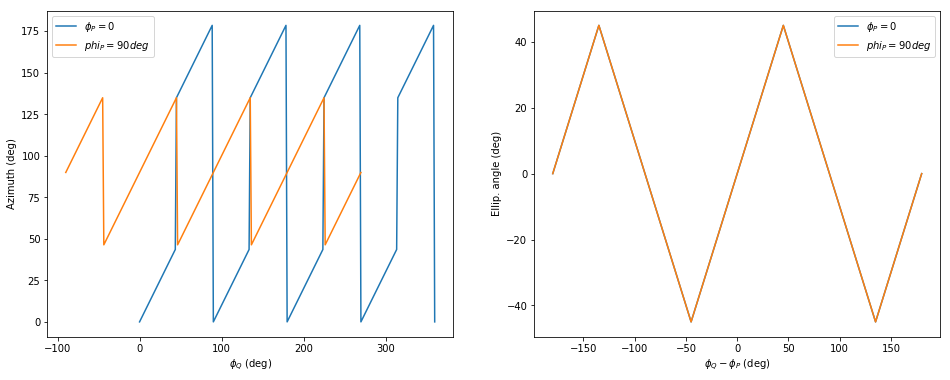

In [17]:
# Crear valores aleatorios
phi_P1 = 180*degrees
phi_Q1 = np.linspace(0, 360*degrees, 257)  # 180 - 360º es igual que 0 - 180º para el azimuth
phi_P2 = 90*degrees
phi_Q2 = np.linspace(-90*degrees, 270*degrees, 257)  # 180 - 360º es igual que 0 - 180º para el azimuth

# Crear las matrices de Jones
P, Q = create_Jones_matrices(N=2)
P.diattenuator_perfect(azimuth=phi_P1)
Q.quarter_waveplate(azimuth=phi_Q1)
E = Jones_vector()
E.linear_light(azimuth=phi_P1) # Da igual qué luz meta, solo afecta a la intensidad final

# Calcular los parámetros del estado de salida.
Ef = Q * P * E
az1, el1 = Ef.parameters.azimuth_ellipticity()

# Crear las matrices de Jones
P.diattenuator_perfect(azimuth=phi_P2)
Q.quarter_waveplate(azimuth=phi_Q2)
E.linear_light(azimuth=phi_P2) # Da igual qué luz meta, solo afecta a la intensidad final

# Calcular los parámetros del estado de salida.
Ef = Q * P * E
az2, el2 = Ef.parameters.azimuth_ellipticity()

# Representar
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot((phi_Q1)/degrees, az1/degrees)
plt.plot((phi_Q2)/degrees, az2/degrees)
plt.xlabel('$\phi_Q$ (deg)')
plt.ylabel('Azimuth (deg)')
plt.legend(('$\phi_P=0$', '$phi_P=90 deg$'))

plt.subplot(1,2,2)
plt.plot((phi_Q1-phi_P1)/degrees, el1/degrees)
plt.plot((phi_Q2-phi_P2)/degrees, el2/degrees)
plt.xlabel('$\phi_Q-\phi_P$ (deg)')
plt.ylabel('Ellip. angle (deg)')
plt.legend(('$\phi_P=0$', '$phi_P=90 deg$'))

Perfecto. Vamos a crear la función de transformación.

In [18]:
def PSG_angles_2_states(phi_P, phi_Q, output='azimuth'):
    """Función que calcula el estado que sale del PSG (con intensidad normalizada) a partir de los ángulos del polarizador y el retardador.
    La salida puede ser tanto en azimut y elipticidad (por defecto) como en alpha y delay (ángulos caracteristicos, paper de Moreno)."""
    # Si son numeros, hacer arrays los ángulos
    phi_Q = np.array(phi_Q % np.pi)
    phi_P = np.array(phi_P % np.pi)
    phi_dif = phi_Q - phi_P
    # Calcular el octante en que se encuentran los ángulos
    Odif = which_quad(phi_dif, octant=True)
    Sdif = np.sign(Odif)
    Odif = np.abs(Odif)
    Oq = which_quad(phi_Q, octant=True)
    Op = which_quad(phi_P, octant=True)
    
    # Primero la elipticidad que es mas facil
    el = deepcopy(phi_dif)
    cond = (Odif > 1.5) * (Odif < 4)
    el[cond] = Sdif[cond] * 90 * degrees - phi_dif[cond]
    cond = Odif >= 4
    el[cond] = phi_dif[cond] - Sdif[cond] * 180*degrees
    # Ahora el azimut. Este depende del azimuth del polarizador
    az = deepcopy(phi_Q)
    cond = (Odif > 1.5) * (Odif < 3.5)
    az[cond] = az[cond] + 90*degrees
    az = az % np.pi
    # Transformar a alpha y delay si hace falta
    if output.upper() != 'AZIMUTH':
        az, el = azimuth_elipt_2_charac_angles(az, el)
    # Return
    return az, el

A ver si funciona.

Text(0, 0.5, 'Ellip. angle (deg)')

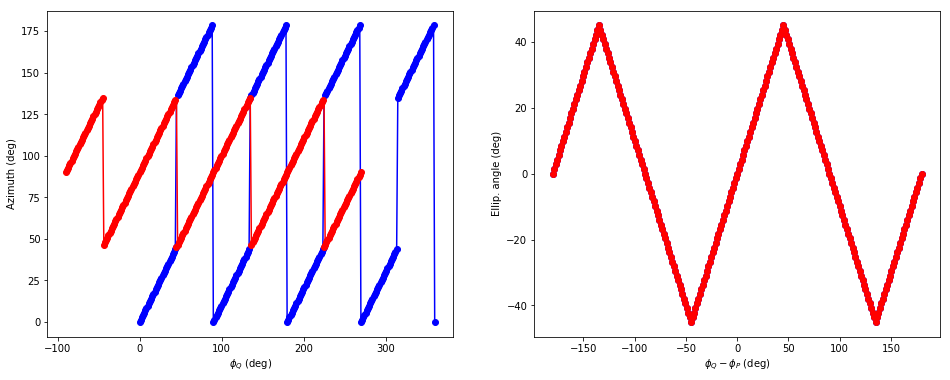

In [19]:
# Comprobacion sencillita pero util para ver qué falla, 1D
# Calcular usando la funcion
az1_calc, el1_calc = PSG_angles_2_states(phi_P1*np.ones_like(phi_Q1), phi_Q1)
az2_calc, el2_calc = PSG_angles_2_states(phi_P2*np.ones_like(phi_Q2), phi_Q2)

# Representar
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot((phi_Q1)/degrees, az1/degrees, 'b')
plt.plot((phi_Q2)/degrees, az2/degrees, 'r')
plt.plot((phi_Q1)/degrees, az1_calc/degrees, 'bo')
plt.plot((phi_Q2)/degrees, az2_calc/degrees, 'ro')
plt.xlabel('$\phi_Q$ (deg)')
plt.ylabel('Azimuth (deg)')

plt.subplot(1,2,2)
plt.plot((phi_Q1-phi_P1)/degrees, el1/degrees, 'b')
plt.plot((phi_Q2-phi_P2)/degrees, el2/degrees, 'r')
plt.plot((phi_Q1-phi_P1)/degrees, el1_calc/degrees, 'bo')
plt.plot((phi_Q2-phi_P2)/degrees, el2_calc/degrees, 'ro')
plt.xlabel('$\phi_Q-\phi_P$ (deg)')
plt.ylabel('Ellip. angle (deg)')

Text(0, 0.5, 'Ellip. angle (deg)')

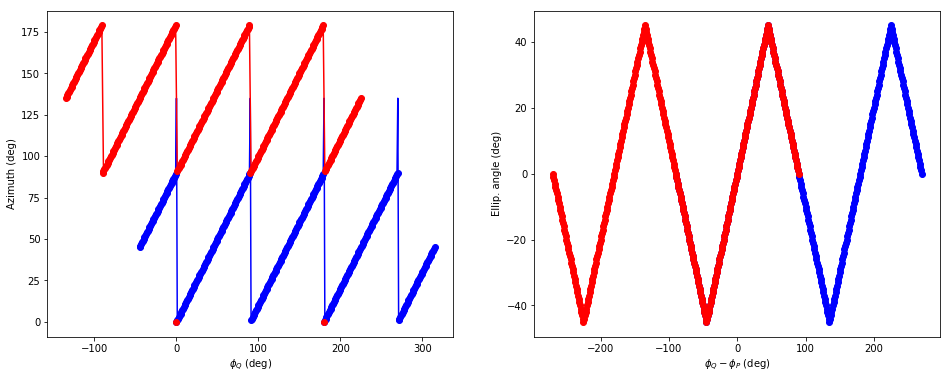

In [20]:
# Lo mismo con 45º y 135º, que parece que dan problemas
# Crear valores aleatorios
phi_P1 = 45*degrees
phi_Q1 = np.linspace(-phi_P1, 360*degrees-phi_P1, 361)  # 180 - 360º es igual que 0 - 180º para el azimuth
phi_P2 = 135*degrees
phi_Q2 = np.linspace(-phi_P2, 360*degrees-phi_P2, 361)  # 180 - 360º es igual que 0 - 180º para el azimuth

# Crear las matrices de Jones
P, Q = create_Jones_matrices(N=2)
P.diattenuator_perfect(azimuth=phi_P1)
Q.quarter_waveplate(azimuth=phi_Q1)
E = Jones_vector()
E.linear_light(azimuth=phi_P1) # Da igual qué luz meta, solo afecta a la intensidad final

# Calcular los parámetros del estado de salida.
Ef = Q * P * E
az1, el1 = Ef.parameters.azimuth_ellipticity()

# Crear las matrices de Jones
P.diattenuator_perfect(azimuth=phi_P2)
Q.quarter_waveplate(azimuth=phi_Q2)
E.linear_light(azimuth=phi_P2) # Da igual qué luz meta, solo afecta a la intensidad final

# Calcular los parámetros del estado de salida.
Ef = Q * P * E
az2, el2 = Ef.parameters.azimuth_ellipticity()

# Calcular usando la funcion
az1_calc, el1_calc = PSG_angles_2_states(phi_P1*np.ones_like(phi_Q1), phi_Q1)
az2_calc, el2_calc = PSG_angles_2_states(phi_P2*np.ones_like(phi_Q2), phi_Q2)

# Representar
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot((phi_Q1)/degrees, az1/degrees, 'b')
plt.plot((phi_Q2)/degrees, az2/degrees, 'r')
plt.plot((phi_Q1)/degrees, az1_calc/degrees, 'bo')
plt.plot((phi_Q2)/degrees, az2_calc/degrees, 'ro')
plt.xlabel('$\phi_Q$ (deg)')
plt.ylabel('Azimuth (deg)')

plt.subplot(1,2,2)
plt.plot((phi_Q1-phi_P1)/degrees, el1/degrees, 'b')
plt.plot((phi_Q2-phi_P2)/degrees, el2/degrees, 'r')
plt.plot((phi_Q1-phi_P1)/degrees, el1_calc/degrees, 'bo')
plt.plot((phi_Q2-phi_P2)/degrees, el2_calc/degrees, 'ro')
plt.xlabel('$\phi_Q-\phi_P$ (deg)')
plt.ylabel('Ellip. angle (deg)')

In [21]:
# Comprobación de que no hay fallos con los valores exactos
# Crear valores aleatorios
phi_P1 = phi_Q1 = np.linspace(0, 180*degrees, 5)
phi_Q1 = np.linspace(0, 180*degrees, 5)
phi_P1, phi_Q1 = np.meshgrid(phi_P1, phi_Q1)

# Crear las matrices de Jones
P, Q = create_Jones_matrices(N=2)
P.diattenuator_perfect(azimuth=phi_P1)
Q.quarter_waveplate(azimuth=phi_Q1)
E = Jones_vector()
E.circular_light(intensity=2) # Da igual qué luz meta, solo afecta a la intensidad final

# Calcular los parámetros del estado de salida.
Ef = Q * P * E
az1, el1 = Ef.parameters.azimuth_ellipticity()

# Calcular el resultado de la funcion
az1_calc, el1_calc = PSG_angles_2_states(phi_P1*np.ones_like(phi_Q1), phi_Q1)
# Representar
print('Angulos iniciales')
print(np.round(phi_P1/degrees), np.round(phi_Q1/degrees), '\n',sep='\n')

print('Elipticidad')
print(np.round(el1/degrees), np.round(el1_calc/degrees), '\n',sep='\n')

print('Azimuth')
print(np.round(az1/degrees), np.round(az1_calc/degrees), '\n',sep='\n')

Angulos iniciales
[[  0.  45.  90. 135. 180.]
 [  0.  45.  90. 135. 180.]
 [  0.  45.  90. 135. 180.]
 [  0.  45.  90. 135. 180.]
 [  0.  45.  90. 135. 180.]]
[[  0.   0.   0.   0.   0.]
 [ 45.  45.  45.  45.  45.]
 [ 90.  90.  90.  90.  90.]
 [135. 135. 135. 135. 135.]
 [180. 180. 180. 180. 180.]]


Elipticidad
[[  0. -45.   0.  45.   0.]
 [ 45.   0. -45.   0.  45.]
 [  0.  45.   0. -45.   0.]
 [-45.   0.  45.   0. -45.]
 [  0. -45.   0.  45.   0.]]
[[  0. -45.   0.  45.   0.]
 [ 45.   0. -45.   0.  45.]
 [  0.  45.   0. -45.   0.]
 [-45.   0.  45.   0. -45.]
 [  0. -45.   0.  45.   0.]]


Azimuth
[[  0. 135.  90. 135.   0.]
 [135.  45. 135. 135. 135.]
 [  0. 135.  90. 135.   0.]
 [135.  45. 135. 135. 135.]
 [  0. 135.  90. 135.   0.]]
[[  0.   0.  90.   0.   0.]
 [ 45.  45.  45. 135.  45.]
 [  0.  90.  90.  90.   0.]
 [135.  45. 135. 135. 135.]
 [  0.   0.  90.   0.   0.]]




Puede parecer que el resultado del azimut no cuadra. Pero eso es en los casos de polarización circular, y ahí el azimut no está definido, por lo que cualquier valor vale.

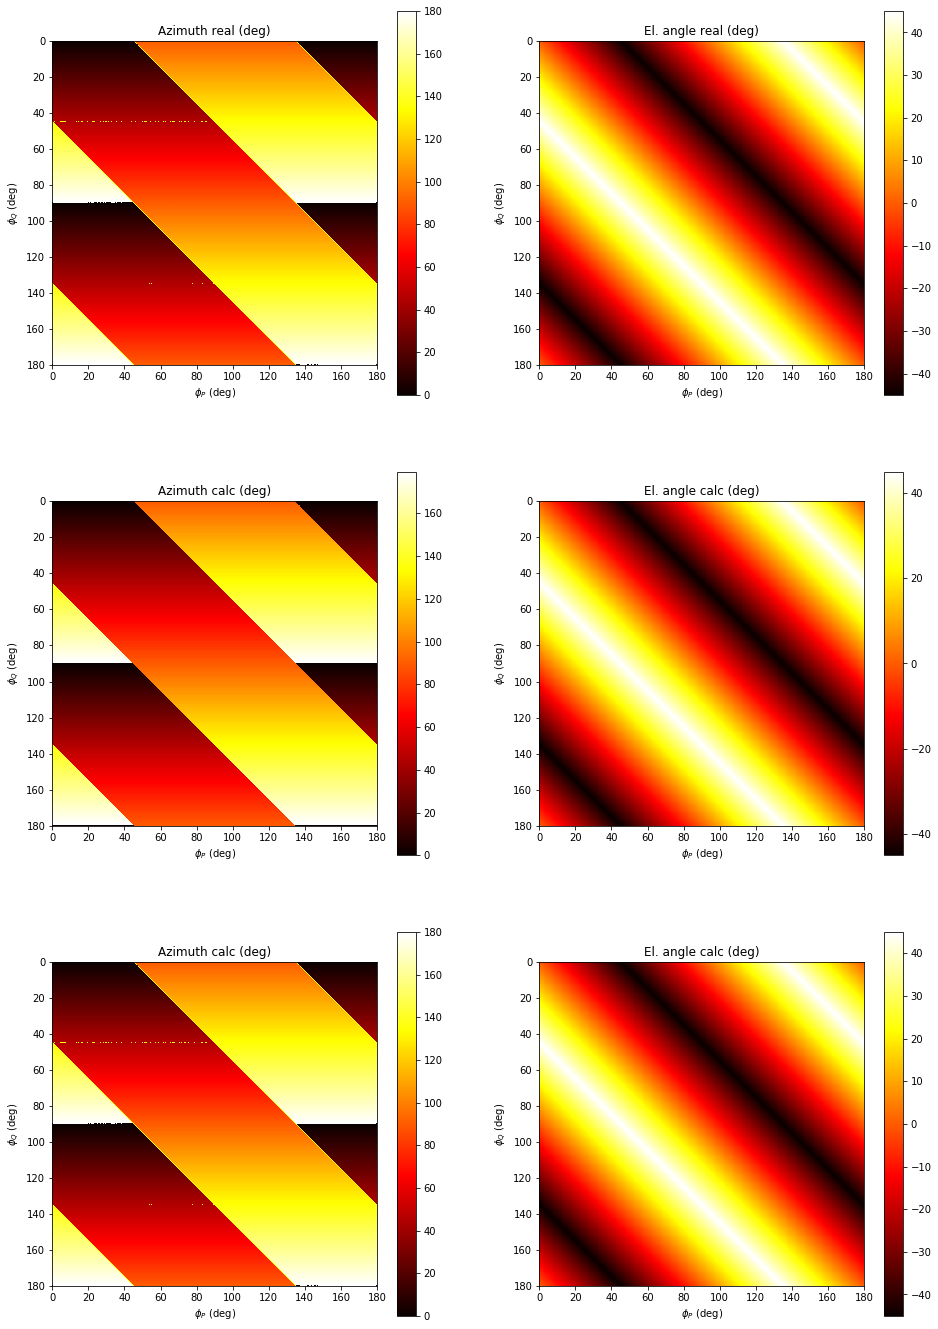

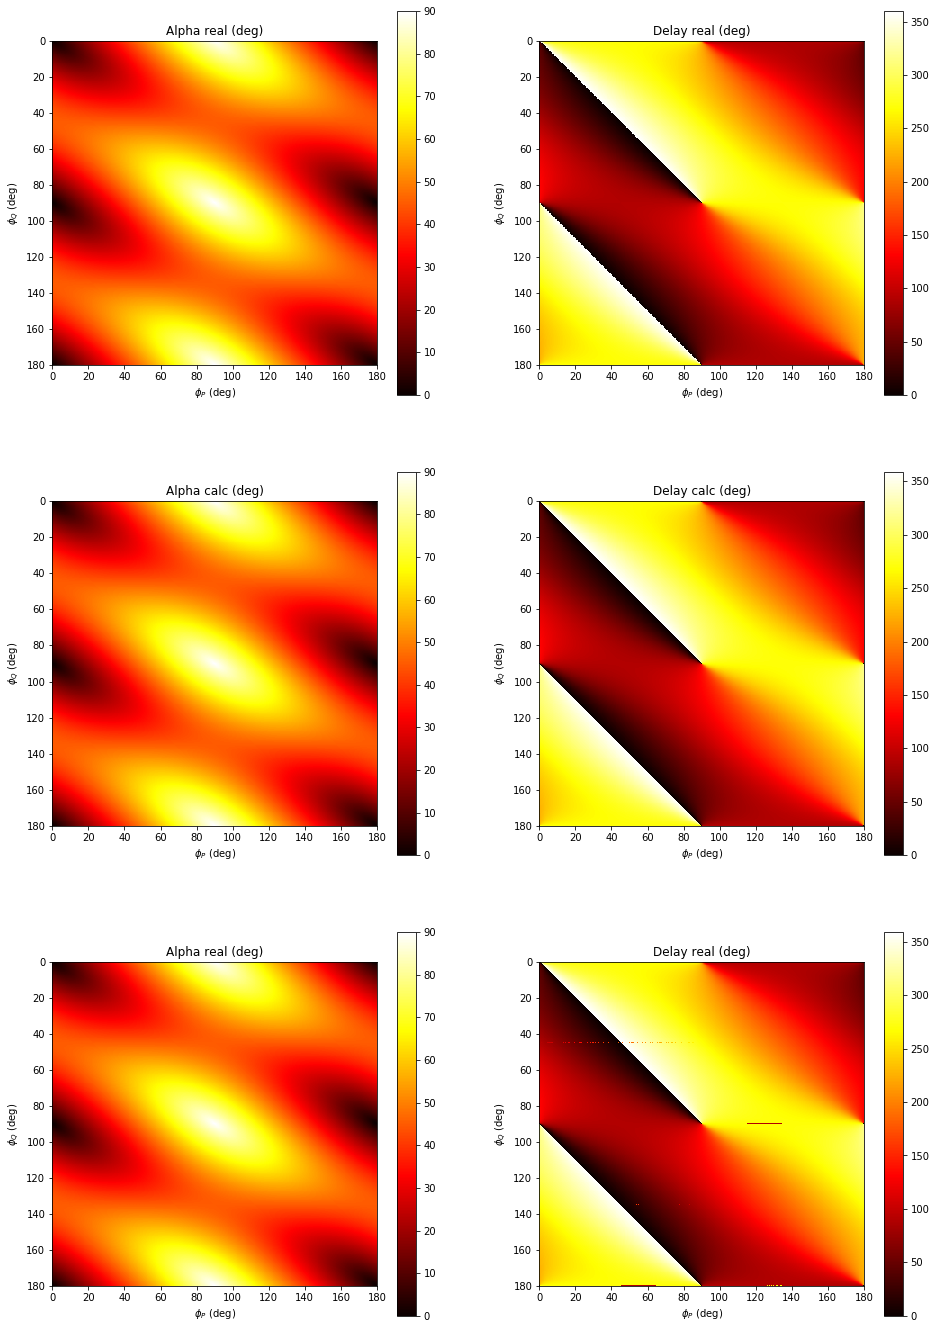

In [22]:
# Comprobacion a lo bestia, 2D
# Crear valores aleatorios
phi_P1 = phi_Q1 = np.linspace(0, 180*degrees, 361)
phi_Q1 = np.linspace(0, 180*degrees, 361)
phi_P1, phi_Q1 = np.meshgrid(phi_P1, phi_Q1)

# Crear las matrices de Jones
P, Q = create_Jones_matrices(N=2)
P.diattenuator_perfect(azimuth=phi_P1)
Q.quarter_waveplate(azimuth=phi_Q1)
E = Jones_vector()
E.circular_light(intensity=2) # Da igual qué luz meta, solo afecta a la intensidad final

# Calcular los parámetros del estado de salida.
Ef = Q * P * E
az1, el1 = Ef.parameters.azimuth_ellipticity()
alpha1, delay1 = Ef.parameters.charac_angles()
az2, el2 = charac_angles_2_azimuth_elipt(alpha1, delay1)
alpha2, delay2 = azimuth_elipt_2_charac_angles(az1, el1)

# Calcular el resultado de la funcion
az1_calc, el1_calc = PSG_angles_2_states(phi_P1*np.ones_like(phi_Q1), phi_Q1)
alpha1_calc, delay1_calc = PSG_angles_2_states(phi_P1*np.ones_like(phi_Q1), phi_Q1, output='char')

# Representar
ext = (phi_P1[0,0]/degrees, phi_P1[-1,-1]/degrees, phi_Q1[-1,-1]/degrees, phi_Q1[0,0]/degrees)
plt.figure(figsize=(16,24))
plt.subplot(3,2,1)
plt.imshow(az1/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Azimuth real (deg)')
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(el1/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('El. angle real (deg)')
plt.colorbar()
plt.subplot(3,2,3)
plt.imshow(az1_calc/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Azimuth calc (deg)')
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(el1_calc/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('El. angle calc (deg)')
plt.colorbar()
plt.subplot(3,2,5)
plt.imshow(az2/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Azimuth calc (deg)')
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(el2/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('El. angle calc (deg)')
plt.colorbar()


plt.figure(figsize=(16,24))
plt.subplot(3,2,1)
plt.imshow(alpha1/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Alpha real (deg)')
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(delay1/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Delay real (deg)')
plt.colorbar()
plt.subplot(3,2,3)
plt.imshow(alpha1_calc/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Alpha calc (deg)')
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(delay1_calc/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Delay calc (deg)')
plt.colorbar()
plt.subplot(3,2,5)
plt.imshow(alpha2/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Alpha real (deg)')
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(delay2/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Delay real (deg)')
plt.colorbar()

Ole!!!!

Vamos a repetir lo mismo en ángulos caracteristicos:

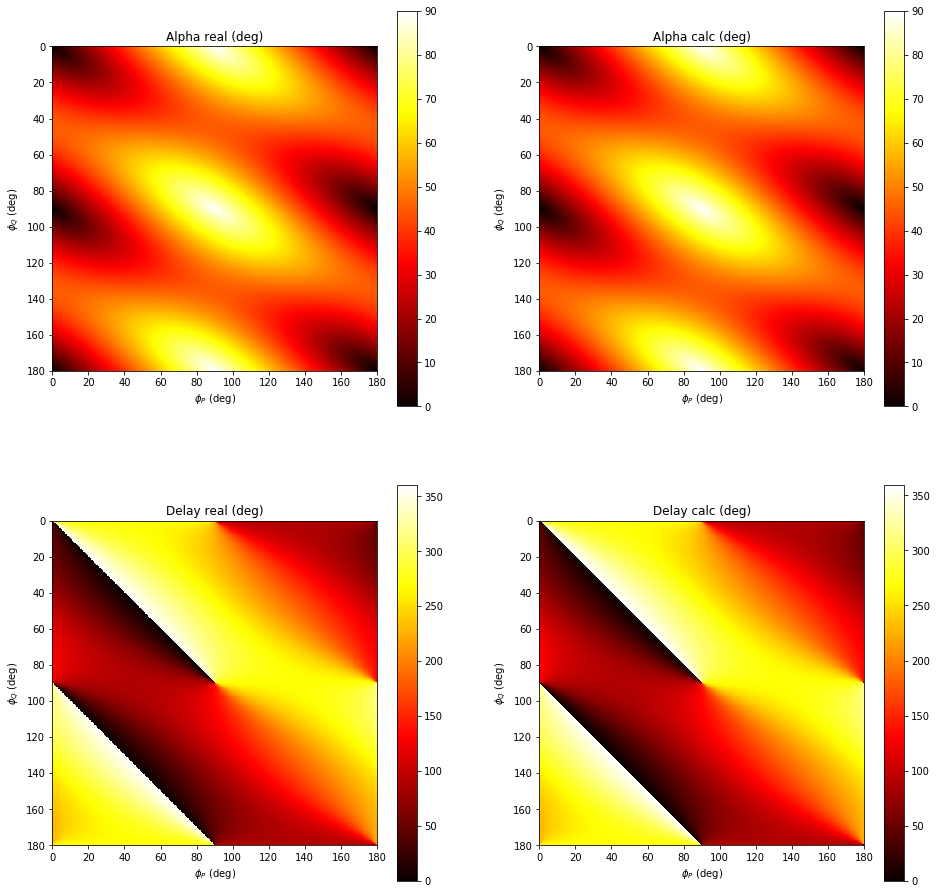

In [23]:
# Comprobacion a lo bestia, 2D
# Crear valores aleatorios
phi_P1 = phi_Q1 = np.linspace(0, 180*degrees, 361)
phi_Q1 = np.linspace(0, 180*degrees, 361)
phi_P1, phi_Q1 = np.meshgrid(phi_P1, phi_Q1)

# Crear las matrices de Jones
P, Q = create_Jones_matrices(N=2)
P.diattenuator_perfect(azimuth=phi_P1)
Q.quarter_waveplate(azimuth=phi_Q1)
E = Jones_vector()
E.circular_light(intensity=2) # Da igual qué luz meta, solo afecta a la intensidad final

# Calcular los parámetros del estado de salida.
Ef = Q * P * E
alpha1, delay1 = Ef.parameters.charac_angles()

# Calcular el resultado de la funcion
alpha1_calc, delay1_calc = PSG_angles_2_states(phi_P1*np.ones_like(phi_Q1), phi_Q1, output='char')
# Representar
ext = (phi_P1[0,0]/degrees, phi_P1[-1,-1]/degrees, phi_Q1[-1,-1]/degrees, phi_Q1[0,0]/degrees)
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.imshow(alpha1/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Alpha real (deg)')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(alpha1_calc/degrees, extent=ext, cmap='hot')
Odif = which_quad(phi_Q1-phi_P1)
# plt.imshow(Odif, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Alpha calc (deg)')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(delay1/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Delay real (deg)')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(delay1_calc/degrees, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Delay calc (deg)')
plt.colorbar()

Esto ya me permite hacer unas ecuaciones generales para pasar de ángulos a estados:

$\chi'=\left\{ \begin{array}{cc}
\phi_{Q}-\phi_{P} & si\:\left|\phi_{Q}-\phi_{P}\right|\leq45\text{º}\\
S\,90\text{º}-\phi_{Q}+\phi_{P} & si\:45\text{º<}\left|\phi_{Q}-\phi_{P}\right|\leq135\text{º}\\
\phi_{Q}-\phi_{P}-S\,180\text{º} & resto
\end{array}\right.$.

$\phi'=\left\{ \begin{array}{cc}
\left(\phi_{Q}+90\text{º}\right)\%180\text{º} & 45\text{º<}\phi_{Q}-\phi_{P}<135\text{º}\\
\phi_{Q} & resto
\end{array}\right.$.

Siendo $S=sign(\phi_{Q}-\phi_{P})$ y $%$ la operación resto de división.

### Generador de estados (estado => ángulos)

La idea es conseguir lo contrario que en el paso anterior, dado un estado, calcular los ángulos necesarios de los elementos del PSG para obtener dicho estado. Para ello, hay que invertir las ecuaciones:

$\phi'=\phi_{Q}$.

$\chi'=\phi_{Q}-\phi_{P}$.

El resultado es:

$\phi_{Q}=\phi'$.

$\phi_{P}=\left(\phi'-\chi'\right)\%180\text{º}$.

Vamos a comprobarlo:

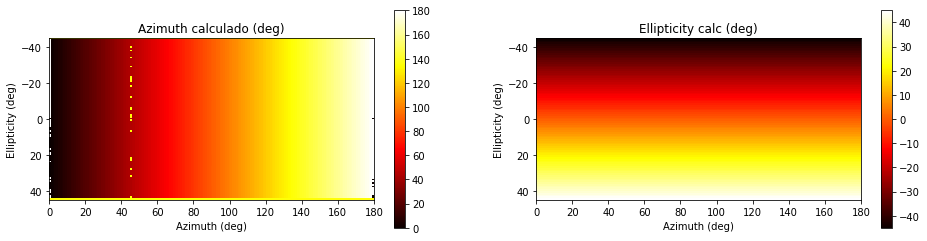

In [24]:
# Crear arrays de valores iniciales
az = np.linspace(0,180*degrees,181)
el = np.linspace(-45*degrees, 45*degrees, 91)
Az, El = np.meshgrid(az, el)

# Hacer el cálculo
phi_Q1 = Az
phi_P1 = (Az - El)%np.pi

# Comprobar que esos cálculos dan los estados de azimuth y elipticidad adecuados
# Crear las matrices de Jones
P1, Q1, P2, Q2 = create_Jones_matrices(N=4)
P1.diattenuator_perfect(azimuth=phi_P1)
Q1.quarter_waveplate(azimuth=phi_Q1)
P2.diattenuator_perfect(azimuth=phi_P2)
Q2.quarter_waveplate(azimuth=phi_Q2)
E = Jones_vector()
E.circular_light(intensity=2) # Da igual qué luz meta, solo afecta a la intensidad final

# Extraer los valores de azimut y elipticidad resultantes
Ef = Q1 * P1 * E
az1, el1 = Ef.parameters.azimuth_ellipticity()

# Representar los resultados
ext = (Az[0,0]/degrees, Az[-1,-1]/degrees, El[-1,-1]/degrees, El[0,0]/degrees)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(az1/degrees, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Azimuth calculado (deg)')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(el1/degrees, extent=ext, cmap='hot')
Odif = which_quad(phi_Q1-phi_P1)
# plt.imshow(Odif, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Ellipticity calc (deg)')
plt.colorbar()

La ecuación para la transformación funciona perfectamente. Solo hay que añadir un detalle, y es que algunos valores especiales permiten más valores posibles de ángulos:

1. $\chi'=0$ (polarización lineal): En ese caso, se puede emplear tanto $\phi_{P}=\left(\phi'-\chi'\right)\%180\text{º}$ como $\phi_{P}=\left(\phi'-\chi'+90\text{º}\right)\%180\text{º}$
1. $\chi'=\pm45\text{º}$ (polarización circular): En ese caso, se puede añadir un ángulo cualquiera a los dos valores calculados, pero el mismo para ambos.

Así que por último, vamos a hacer una función de conversión (que en este caso es muy sencillita). Para que la puedas usar con lo que viene en el paper de Moreno, te voy a añadir la opcion de meterle los datos en alpha y delay.

In [25]:
def PSG_states_2_angles(azimuth=None, ellipticity=None, alpha=None, delay=None):
    """Función para pasar de estados a ángulos de giro de los elementos del PSG. 
    Únicamente hay que darle un par de valores, azimut y elipticidad o alpha y delay (ángulos característicos, paper de Moreno).
    Si se dan ambas combinaciones, los ángulos característicos prevalecen."""
    # Transformar si es necesario
    if alpha is not None and delay is not None:
        azimuth, ellipticity = charac_angles_2_azimuth_elipt(alpha, delay)
    # Hacer el cáclculo
    angle_R = azimuth
    angle_P = (azimuth - ellipticity)%np.pi
    # Return
    return angle_P, angle_R

### Analizador de estados (estados)

Pues vamos a hacer el cálculo al contrario:

$A(\phi_{P},\phi_{Q})=P(\phi_{P})Q(\phi_{Q})=$.

$A(\phi_{P},\phi_{Q})=\left\langle \phi_{P},0\right|\left.\phi_{Q},0\right\rangle \left|\phi_{P},0\right\rangle \left\langle \phi_{Q},0\right|-i\left\langle \phi_{P},0\right|\left.\phi_{Q\bot},0\right\rangle \left|\phi_{P},0\right\rangle \left\langle \phi_{Q\bot},0\right|=$.

$\qquad\qquad=\cos(\phi_{Q}-\phi_{P})\left|\phi_{P},0\right\rangle \left\langle \phi_{Q},0\right|-i\sin(\phi_{Q}-\phi_{P})\left|\phi_{P},0\right\rangle \left\langle \phi_{Q\bot},0\right|=$.

$\qquad\qquad=\left|\phi_{P},0\right\rangle \left\langle \phi',\chi'\right|$.

El resultado es análogo al obtenido en el PSG, con la diferencia que el estado de salida del PSA será siempre $\left|\phi_{P},0\right\rangle$, y el estado considerado primario del PSA (\left\langle \phi',\chi'\right|) lo que hace es variar la intensidad dependiendo de la luz que le llegue. Las ecuaciones que relacionan estos parámetros con los ángulos de los elementos son ligeramente diferentes porque un ket es el hermítico conjugado de un bra, y eso cambia el signo de la elipticidad:

$\phi'=\phi_{Q}$.

$\chi'=\phi_{P}-\phi_{Q}$.

La transformación iversa sería:

$\phi_{Q}=\phi'$.

$\phi_{P}=\left(\phi'+\chi'\right)\%180\text{º}$.

Con unas ecuaciones de transformación tan parecidas, las funciones de transformación son también parecidas.

In [26]:
def PSA_angles_2_states(phi_P, phi_Q, output='azimuth'):
    """Función que calcula el estado de máxima transmitancia del analizador de estados (con intensidad normalizada) a partir de los ángulos del polarizador 
    y el retardador. La salida puede ser tanto en azimut y elipticidad (por defecto) como en alpha y delay (ángulos caracteristicos, paper de Moreno)."""
    # Si son numeros, hacer arrays los ángulos
    phi_Q = np.array(phi_Q % np.pi)
    phi_P = np.array(phi_P % np.pi)
    phi_dif = phi_P - phi_Q
    # Calcular el octante en que se encuentran los ángulos
    Odif = which_quad(phi_dif, octant=True)
    Sdif = np.sign(Odif)
    Odif = np.abs(Odif)
    Oq = which_quad(phi_Q, octant=True)
    Op = which_quad(phi_P, octant=True)
    
    # Primero la elipticidad que es mas facil
    el = deepcopy(phi_dif)
    cond = (Odif > 1.5) * (Odif < 4)
    el[cond] = Sdif[cond] * 90 * degrees - phi_dif[cond]
    cond = Odif >= 4
    el[cond] = phi_dif[cond] - Sdif[cond] * 180*degrees
    # Ahora el azimut. Este depende del azimuth del polarizador
    az = deepcopy(phi_Q)
    cond = (Odif > 1.5) * (Odif < 3.5)
    az[cond] = az[cond] + 90*degrees
    az = az % np.pi
    # Transformar a alpha y delay si hace falta
    if output.upper() != 'AZIMUTH':
        az, el = azimuth_elipt_2_charac_angles(az, el)
    # Return
    return az, el

In [27]:
def PSA_states_2_angles(azimuth=None, ellipticity=None, alpha=None, delay=None):
    """Función para pasar de estados a ángulos de giro de los elementos del analizador de estados. 
    Únicamente hay que darle un par de valores, azimut y elipticidad o alpha y delay (ángulos característicos, paper de Moreno).
    Si se dan ambas combinaciones, los ángulos característicos prevalecen."""
    # Transformar si es necesario
    if alpha is not None and delay is not None:
        azimuth, ellipticity = charac_angles_2_azimuth_elipt(alpha, delay)
    # Hacer el cáclculo
    angle_R = azimuth
    angle_P = (azimuth + ellipticity)%np.pi
    # Return
    return angle_P, angle_R

Vamos a comprobar que funcionan.

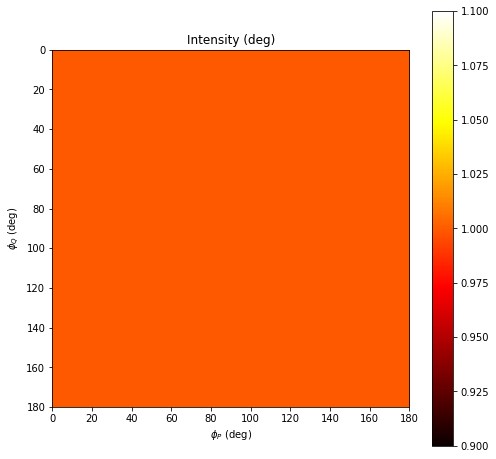

In [28]:
# Crear valores aleatorios
phi_P = np.linspace(0, 180*degrees, 181)
phi_Q = np.linspace(0, 180*degrees, 181)
phi_P, phi_Q = np.meshgrid(phi_P, phi_Q)

# Calcular los valores de azimut y elipticidad
Azimuth, Ellipticity = PSA_angles_2_states(phi_P, phi_Q)

# Crear las matrices de Jones
P, Q = create_Jones_matrices(N=2)
P.diattenuator_perfect(azimuth=phi_P)
Q.quarter_waveplate(azimuth=phi_Q)

# Calcular el vector de Jones de maxima transmitancia
E = Jones_vector()
E.general_azimuth_ellipticity(intensity=1, azimuth=Azimuth, ellipticity=Ellipticity) 

# Calcular la intensidad del estado de salida.
Ef = P * Q * E
I = Ef.parameters.intensity()
I = np.around(I, decimals=4)

# Representar
ext = (phi_P[0,0]/degrees, phi_P[-1,-1]/degrees, phi_Q[-1,-1]/degrees, phi_Q[0,0]/degrees)
plt.figure(figsize=(8,8))
plt.imshow(I, extent=ext, cmap='hot')
plt.xlabel('$\phi_P$ (deg)')
plt.ylabel('$\phi_Q$ (deg)')
plt.title('Intensity (deg)')
plt.colorbar()

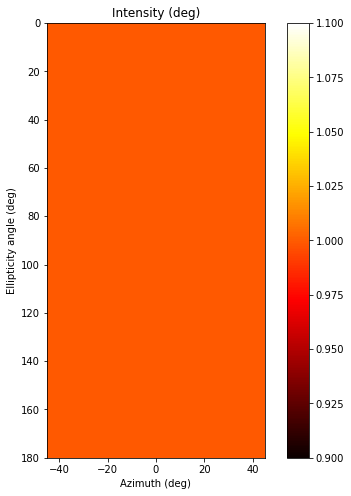

In [29]:
# Crear valores aleatorios
Azimuth = np.linspace(0, 180*degrees, 181)
Ellipticity = np.linspace(-45*degrees, 45*degrees, 91)
Azimuth, Ellipticity = np.meshgrid(Azimuth, Ellipticity)

# Calcular los valores de azimut y elipticidad
phi_P, phi_Q = PSA_states_2_angles(Azimuth, Ellipticity)

# Crear las matrices de Jones
P, Q = create_Jones_matrices(N=2)
P.diattenuator_perfect(azimuth=phi_P)
Q.quarter_waveplate(azimuth=phi_Q)

# Calcular el vector de Jones de maxima transmitancia
E = Jones_vector()
E.general_azimuth_ellipticity(intensity=1, azimuth=Azimuth, ellipticity=Ellipticity) 

# Calcular la intensidad del estado de salida.
Ef = P * Q * E
I = Ef.parameters.intensity()
I = np.around(I, decimals=4)

# Representar
ext = (Ellipticity[0,0]/degrees, Ellipticity[-1,-1]/degrees, Azimuth[-1,-1]/degrees, Azimuth[0,0]/degrees)
plt.figure(figsize=(8,8))
plt.imshow(I, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity angle (deg)')
plt.title('Intensity (deg)')
plt.colorbar()

Pues ya hemos comprobado que las funciones tienen el resultado esperado. Las ecuaciones de transformación quedan:

$\chi'=\left\{ \begin{array}{cc}
\phi_{P}-\phi_{Q} & si\:\left|\phi_{P}-\phi_{Q}\right|\leq45\text{º}\\
S\,90\text{º}-\phi_{P}+\phi_{Q} & si\:45\text{º<}\left|\phi_{P}-\phi_{Q}\right|\leq135\text{º}\\
\phi_{P}-\phi_{Q}-S\,180\text{º} & resto
\end{array}\right.$.

$\phi'=\left\{ \begin{array}{cc}
\left(\phi_{Q}+90\text{º}\right)\%180\text{º} & 45\text{º<}\phi_{P}-\phi_{Q}<135\text{º}\\
\phi_{Q} & resto
\end{array}\right.$.

$\phi_{Q}=\phi'$.

$\phi_{P}=\left(\phi'+\chi'\right)\%180\text{º}$.

Siendo $S = sign(\phi_{P}-\phi_{Q})$. Y hay que añadir que cuando $\chi=0$, también vale $\phi_{Q}=\left(\phi'+90\text{º}\right)\%180\text{º}$, y que cuando $\chi=\pm45\text{º}$, se puede añadir un ángulo arbitrario tanto a $\phi_P$ como $\phi_Q$ (pero el mismo para los dos).

## Test duro: modelo de Moreno

Vamos a ver si funciona de una vez el calculo de matriz de Mueller usando el modelo de Moreno.

In [30]:
# Crear las variables de angulos
alpha_A = np.array([0, 90, 45, 90, 0, 90, 45]) * degrees
delay_A = np.array([0, 0, 270, 0, 0, 0, 0]) * degrees
alpha_G = np.array([0, 0, 0, 45, 45, 45, 0]) * degrees
delay_G = np.array([0, 0, 0, 90, 0, 0, 0]) * degrees

# Transformar a angulos
angle_P1, angle_Q1 = PSG_states_2_angles(alpha=alpha_G, delay=delay_G)
angle_P2, angle_Q2 = PSA_states_2_angles(alpha=alpha_A, delay=delay_A)
print('P1',np.round(angle_P1/degrees))
print('Q1',np.round(angle_Q1/degrees))
print('Q2',np.round(angle_Q2/degrees))
print('P2',np.round(angle_P2/degrees))

# Crear una matriz random
X, Y, Z, W = np.random.rand(4) * np.array([1, 2, 2, 2]) - np.array([0, 1, 1, 1])
M = [[X - 1j*Y, Z - 1j * W], [-Z - 1j*W, X + 1j * Y]]

# Crear los objetos pypol
P1, Q1, P2, Q2, J = create_Jones_matrices(N=5)
P1.diattenuator_perfect(azimuth=angle_P1)
P2.diattenuator_perfect(azimuth=angle_P2)
Q1.quarter_waveplate(azimuth=angle_Q1)
Q2.quarter_waveplate(azimuth=angle_Q2)
J.from_matrix(M)
E = Jones_vector()
E.circular_light()

# Calculate the intensities and normalize them
Ef = P2 * Q2 * J * Q1 * P1 * E
I = Ef.parameters.intensity()
P1.diattenuator_perfect(azimuth=0)
Ef = P1 * P1 * E
I = I / Ef.parameters.intensity()

# Calcular los parámetros de la matriz
X2 = I[0] / (1 + ((I[6]-I[5])/(I[2]-I[3]))**2)
Y2 = I[0] / (1 + ((I[2]-I[3])/(I[6]-I[5]))**2)
Z2 = I[1] / (1 + ((I[2]-I[3])/(I[4]-I[6]))**2)
W2 = I[1] / (1 + ((I[4]-I[6])/(I[2]-I[3]))**2)
X = np.sqrt(X2)
Y = np.sqrt(Y2)
Z = np.sqrt(Z2)
W = np.sqrt(W2)
sZ = np.sign(I[4] - I[6])
sW = np.sign(I[2] - I[3])
sY = np.sign(I[6] - I[5]) / sW

# Crear la matriz calculada
M2 = [[X - 1j*sY*Y, sZ*Z - 1j * sW*W], [-sZ*Z - 1j*sW*W, X + 1j * sY*Y]]
print(M)
print(M2)

P1 [ 0.  0.  0. 90. 45. 45.  0.]
Q1 [  0.   0.   0. 135.  45.  45.   0.]
Q2 [  0.  90. 135.  90.   0.  90.  45.]
P2 [ 0. 90. 90. 90.  0. 90. 45.]
[[(0.9176572519077869+0.7000179489041187j), (0.013208768559120676+0.39685988819218965j)], [(-0.013208768559120676+0.39685988819218965j), (0.9176572519077869-0.7000179489041187j)]]
[[(0.9176572519077869+0.7000179489041188j), (0.013208768559120775+0.39685988819218965j)], [(-0.013208768559120775+0.39685988819218965j), (0.9176572519077869-0.7000179489041188j)]]


Funciona!!!!!

## Recapitulación de nuestro método: Dar estados en lugar de ángulos

Fácil, pasar los ángulos que calculé en la sección anterior para mi método a estados.

In [31]:
# Ángulos. Ya vi anteriormente que las 4 combinaciones corresponden a los mismos estados debido a la incertidumbre generada.
angle_P1 = np.array([0, 0, 90, 90, 0, 45, 0, 0, 45, 45, 0, 135, 0, 0, 45, 135]) * degrees
angle_R1 = np.array([0, 0, 0, 0, 135, 45, 0, 0, 0, 45, 45, 45, 0, 0, 90, 45]) * degrees
angle_R2 = np.array([0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 45, 0, 0]) * degrees
angle_P2 = np.array([0, 90, 90, 0, 0, 0, 45, 45, 90, 90, 0, 0, 135, 135, 90, 90]) * degrees

# Transformar a azimuth y elipticidad
az_G, el_G = PSG_angles_2_states(angle_P1, angle_R1)
az_A, el_A = PSA_angles_2_states(angle_P2, angle_R2)
print('Generador (azimut - elipticidad):')
print(np.around(az_G/degrees, decimals=0))
print(np.around(el_G/degrees, decimals=0))
print('Analizador (azimut - elipticidad):')
print(np.around(az_A/degrees, decimals=0))
print(np.around(el_A/degrees, decimals=0))

# Transformar a angulos caracteristicos
alpha_G, delay_G = PSG_angles_2_states(angle_P1, angle_R1, output='charac')
alpha_A, delay_A = PSA_angles_2_states(angle_P2, angle_R2, output='charac')
print('Generador (caac. angles):')
print(np.around(alpha_G/degrees, decimals=0))
print(np.around(delay_G/degrees, decimals=0))
print('Analizador (caac. angles):')
print(np.around(alpha_A/degrees, decimals=0))
print(np.around(delay_A/degrees, decimals=0))

# Representacion para escribir facil
M = np.array([alpha_A, delay_A, az_A, el_A, alpha_G, delay_G, az_G, el_G])
print('Sacar estados en funcion de I')
print(np.around(np.transpose(M)/degrees, decimals=0))
for ind in range(16):
    print('\n- I{}: Ap1 = {}, Ar1 = {}, Ar2 = {}, Ap2 = {}'.format(ind+1, angle_P1[ind]/degrees, angle_R1[ind]/degrees, angle_R2[ind]/degrees, angle_P2[ind]/degrees))
    print('- I{}: Aa = {}, Da = {}, Pa = {}, Xa = {}'.format(ind+1, alpha_A[ind]/degrees, delay_A[ind]/degrees, az_A[ind]/degrees, el_A[ind]/degrees))
    print('- I{}: Ag = {}, Dg = {}, Pg = {}, Xg = {}'.format(ind+1, alpha_G[ind]/degrees, delay_G[ind]/degrees, az_G[ind]/degrees, el_G[ind]/degrees))

Generador (azimut - elipticidad):
[  0.   0.  90.  90. 135.  45.   0.   0.   0.  45.  45. 135.   0.   0.
  90. 135.]
[  0.   0.   0.   0. -45.   0.   0.   0. -45.   0.  45.   0.   0.   0.
  45.   0.]
Analizador (azimut - elipticidad):
[  0.  90.  90.   0.   0.   0.   0.  45.  90.  90.   0.   0.   0. 135.
  90.  90.]
[  0.   0.   0.   0.   0.   0.  45.   0.   0.   0.   0.   0. -45.   0.
   0.   0.]
Generador (caac. angles):
[ 0.  0. 90. 90. 45. 45.  0.  0. 45. 45. 45. 45.  0.  0. 45. 45.]
[  0.   0.   0.   0. 270.   0.   0.   0. 270.   0.  90. 180.   0.   0.
  90. 180.]
Analizador (caac. angles):
[ 0. 90. 90.  0.  0.  0. 45. 45. 90. 90.  0.  0. 45. 45. 90. 90.]
[  0.   0.   0.   0.   0.   0.  90.   0.   0.   0.   0.   0. 270. 180.
   0.   0.]
Sacar estados en funcion de I
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [ 90.   0.  90.   0.   0.   0.   0.   0.]
 [ 90.   0.  90.   0.  90.   0.  90.   0.]
 [  0.   0.   0.   0.  90.   0.  90.   0.]
 [  0.   0.   0.   0.  45. 270. 135. -45.]
 [ 

Aquí están los estados de todas las medidas. También he incluido cuales son las medidas del método de Moreno ($I_{Mi}$):

$I_{1}=\left\langle \alpha=0\text{º,\ensuremath{\delta=}0º//\ensuremath{\phi=0\text{º,\ensuremath{\chi=0\text{º}}}}}\right|J\left|\alpha=0\text{º,\ensuremath{\delta=}0º//\ensuremath{\phi=0\text{º,\ensuremath{\chi=0\text{º}}}}}\right\rangle =I_{M1}$.

$I_{2}=\left\langle \alpha=90\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=}0\text{º}}}\right|J\left|\alpha=0\text{º},\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=}0\text{º}}\right\rangle =I_{M2}$.

$I_{3}=\left\langle \alpha=90\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=0\text{º}}}}\right|J\left|\alpha=90\text{º},\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=0\text{º}}}\right\rangle $.

$I_{4}=\left\langle \alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right|J\left|\alpha=90\text{º},\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=0\text{º}}}\right\rangle $.

$I_{5}=\left\langle \alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=270\text{º}}//\ensuremath{\phi=ind.,\ensuremath{\chi=-45\text{º}}}\right\rangle $.

$I_{6}=\left\langle \alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=45\text{º},\ensuremath{\chi=0\text{º}}}\right\rangle =I_{M5}$.

$I_{7}=\left\langle \alpha=45\text{º}\text{,\ensuremath{\delta=270\text{º}}//\ensuremath{\phi=ind.,\ensuremath{\chi=-45\text{º}}}}\right|J\left|\alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right\rangle =I_{M3}$.

$I_{8}=\left\langle \alpha=45\text{º},\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=45\text{º},\ensuremath{\chi=0\text{º}}}\right|J\left|\alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right\rangle =I_{M7}$.

$I_{9}=\left\langle \alpha=90\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=}0\text{º}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=45\text{º},\ensuremath{\chi=0\text{º}}}\right\rangle =I_{M6}$.

$I_{10}=\left\langle \alpha=90\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=}0\text{º}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=45\text{º},\ensuremath{\chi=0\text{º}}}\right\rangle $.

$I_{11}=\left\langle \alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=90\text{º}}//\ensuremath{\phi=ind.,\ensuremath{\chi=}45\text{º}}\right\rangle $.

$I_{12}=\left\langle \alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=180\text{º}}//\ensuremath{\phi=135\text{º},\ensuremath{\chi=0\text{º}}}\right\rangle $.

$I_{13}=\left\langle \alpha=45\text{º},\ensuremath{\delta=90\text{º}}//\ensuremath{\phi=ind.,\ensuremath{\chi=}45\text{º}}\right|J\left|\alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right\rangle $.

$I_{14}=\left\langle \alpha=45\text{º},\ensuremath{\delta=180\text{º}}//\ensuremath{\phi=135\text{º},\ensuremath{\chi=0\text{º}}}\right|J\left|\alpha=0\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=0\text{º},\ensuremath{\chi=0\text{º}}}}\right\rangle $.

$I_{15}=\left\langle \alpha=90\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=}0\text{º}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=90\text{º}}//\ensuremath{\phi=ind.,\ensuremath{\chi=}45\text{º}}\right\rangle =I_{M4}$.

$I_{16}=\left\langle \alpha=90\text{º}\text{,\ensuremath{\delta=0\text{º}}//\ensuremath{\phi=90\text{º},\ensuremath{\chi=}0\text{º}}}\right|J\left|\alpha=45\text{º},\ensuremath{\delta=180\text{º}}//\ensuremath{\phi=135\text{º},\ensuremath{\chi=0\text{º}}}\right\rangle $.

## Pruebas

In [32]:
alpha_A = np.array([0, 90, 45, 90, 0, 90, 45]) * degrees
delay_A = np.array([0, 0, 270, 0, 0, 0, 0]) * degrees
alpha_G = np.array([0, 0, 0, 45, 45, 45, 0]) * degrees
delay_G = np.array([0, 0, 0, 90, 0, 0, 0]) * degrees

# Transformar a angulos
angle_P1, angle_Q1 = PSG_states_2_angles(alpha=alpha_G, delay=delay_G)
angle_P2, angle_Q2 = PSA_states_2_angles(alpha=alpha_A, delay=delay_A)

# Transformacion inversa
alpha_G2, delay_G2 = PSG_angles_2_states(angle_P1, angle_Q1, output='charac')
alpha_A2, delay_A2 = PSA_angles_2_states(angle_P1, angle_Q1, output='charac')

# Representar
print('\nAlpha generator', alpha_G/degrees, alpha_G2/degrees, sep='\n')
print('\nAlpha analyzer', alpha_A/degrees, alpha_A2/degrees, sep='\n')
print('\nDelay generator', delay_G/degrees, delay_G2/degrees, sep='\n')
print('\nDelay analyzer', delay_A/degrees, delay_A2/degrees, sep='\n')


Alpha generator
[ 0.  0.  0. 45. 45. 45.  0.]
[ 0.  0.  0. 45. 45. 45.  0.]

Alpha analyzer
[ 0. 90. 45. 90.  0. 90. 45.]
[ 0.  0.  0. 45. 45. 45.  0.]

Delay generator
[ 0.  0.  0. 90.  0.  0.  0.]
[ 0.  0.  0. 90.  0.  0.  0.]

Delay analyzer
[  0.   0. 270.   0.   0.   0.   0.]
[  0.   0.   0. 270.   0.   0.   0.]


In [33]:
alpha = np.linspace(0, 90*degrees, 3)
delay = np.linspace(0, 360*degrees, 9)
Alpha, Delay = np.meshgrid(alpha, delay)

angle_P1, angle_Q1 = PSG_states_2_angles(alpha=Alpha, delay=Delay)
angle_P2, angle_Q2 = PSA_states_2_angles(alpha=Alpha, delay=Delay)

# Transformacion inversa
alpha_G2, delay_G2 = PSG_angles_2_states(angle_P1, angle_Q1, output='charac')
alpha_A2, delay_A2 = PSA_angles_2_states(angle_P2, angle_Q2, output='charac')

# Representar
print('\nAlpha generator',  alpha_G2/degrees, sep='\n')
print('\nAlpha analyzer',  alpha_A2/degrees, sep='\n')
print('\nDelay generator', delay_G2/degrees, sep='\n')
print('\nDelay analyzer', delay_A2/degrees, sep='\n')


Alpha generator
[[ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]]

Alpha analyzer
[[ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]]

Delay generator
[[  0.   0.   0.]
 [  0.  45.   0.]
 [  0.  90.   0.]
 [  0. 135.   0.]
 [  0. 180.   0.]
 [  0. 225.   0.]
 [  0. 270.   0.]
 [  0. 315.   0.]
 [  0.   0.   0.]]

Delay analyzer
[[  0.   0.   0.]
 [  0.  45.   0.]
 [  0.  90.   0.]
 [  0. 135.   0.]
 [  0. 180.   0.]
 [  0. 225.   0.]
 [  0. 270.   0.]
 [  0. 315.   0.]
 [  0.   0.   0.]]


In [34]:
az = np.linspace(0, 180*degrees, 9)
el = np.linspace(-45*degrees, 45*degrees, 5)
Az, El = np.meshgrid(az, el)

angle_P1, angle_Q1 = PSG_states_2_angles(azimuth=Az, ellipticity=El)
angle_P2, angle_Q2 = PSA_states_2_angles(azimuth=Az, ellipticity=El)

# Transformacion inversa
Az_G2, El_G2 = PSG_angles_2_states(angle_P1, angle_Q1)
Az_A2, El_A2 = PSA_angles_2_states(angle_P2, angle_Q2)

# Representar
print('\nAzimuth generator',  Az_G2/degrees, sep='\n')
print('\nAzimuth analyzer',  Az_A2/degrees, sep='\n')
print('\nEllipticity generator', El_G2/degrees, sep='\n')
print('\nEllipticity analyzer', El_A2/degrees, sep='\n')


Azimuth generator
[[  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]]

Azimuth analyzer
[[  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]
 [  0.   22.5  45.   67.5  90.  112.5 135.  157.5   0. ]]

Ellipticity generator
[[-45.  -45.  -45.  -45.  -45.  -45.  -45.  -45.  -45. ]
 [-22.5 -22.5 -22.5 -22.5 -22.5 -22.5 -22.5 -22.5 -22.5]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ 22.5  22.5  22.5  22.5  22.5  22.5  22.5  22.5  22.5]
 [ 45.   45.   45.   45.   45.   45.   45.   45.   45. ]]

Ellipticity analyzer
[[-45.  -45.  -45.  -45.  -45.  -45.  -45.  -45.  -45. ]
 [-

In [35]:
Alpha, Delay = azimuth_elipt_2_charac_angles(Az, El)
Alpha2, Delay2 = azimuth_elipt_2_charac_angles(Az_G2, El_G2)

# Representar
# print('\nAlpha 0',  Alpha/degrees, sep='\n')
# print('\nAlpha 1',  Alpha2/degrees, sep='\n')
# print('\nDelay 0', Delay/degrees, sep='\n')
# print('\nDelay 1', Delay2/degrees, sep='\n')
print(Alpha==Alpha2)
print(Delay==Delay2)

[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]


In [36]:
a, d = PSA_angles_2_states(np.array([0, 45*degrees]), np.array([45*degrees, 0]), output='charac')
print(a/degrees,d/degrees)

[45. 45.] [270.  90.]


In [37]:
alpha = np.linspace(0, 90*degrees, 3)
delay = np.linspace(0, 360*degrees, 5)
Alpha, Delay = np.meshgrid(alpha, delay)

Az, El = charac_angles_2_azimuth_elipt(Alpha, Delay)
Alpha2, Delay2 = azimuth_elipt_2_charac_angles(Az, El)

print(Alpha/degrees, Alpha2/degrees, Delay/degrees, Delay2/degrees, sep='\n')

[[ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]]
[[ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]
 [ 0. 45. 90.]]
[[  0.   0.   0.]
 [ 90.  90.  90.]
 [180. 180. 180.]
 [270. 270. 270.]
 [360. 360. 360.]]
[[  0.   0.   0.]
 [  0.  90.   0.]
 [  0. 180.   0.]
 [  0. 270.   0.]
 [  0.   0.   0.]]


In [38]:
az = np.linspace(0, 180*degrees, 5)
el = np.linspace(-45*degrees, 45*degrees, 3)
Az, El = np.meshgrid(az, el)

Alpha, Delay = azimuth_elipt_2_charac_angles(Az, El)
Az2, El2 = charac_angles_2_azimuth_elipt(Alpha, Delay)

print(Az/degrees, Az2/degrees, El/degrees, El2/degrees, sep='\n')

[[  0.  45.  90. 135. 180.]
 [  0.  45.  90. 135. 180.]
 [  0.  45.  90. 135. 180.]]
[[135. 135. 135. 135. 135.]
 [  0.  45.  90. 135.   0.]
 [135. 135. 135. 135. 135.]]
[[-45. -45. -45. -45. -45.]
 [  0.   0.   0.   0.   0.]
 [ 45.  45.  45.  45.  45.]]
[[-4.50000000e+01 -4.50000000e+01 -4.50000000e+01 -4.50000000e+01
  -4.50000000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.50835465e-15
   0.00000000e+00]
 [ 4.50000000e+01  4.50000000e+01  4.50000000e+01  4.50000000e+01
   4.50000000e+01]]


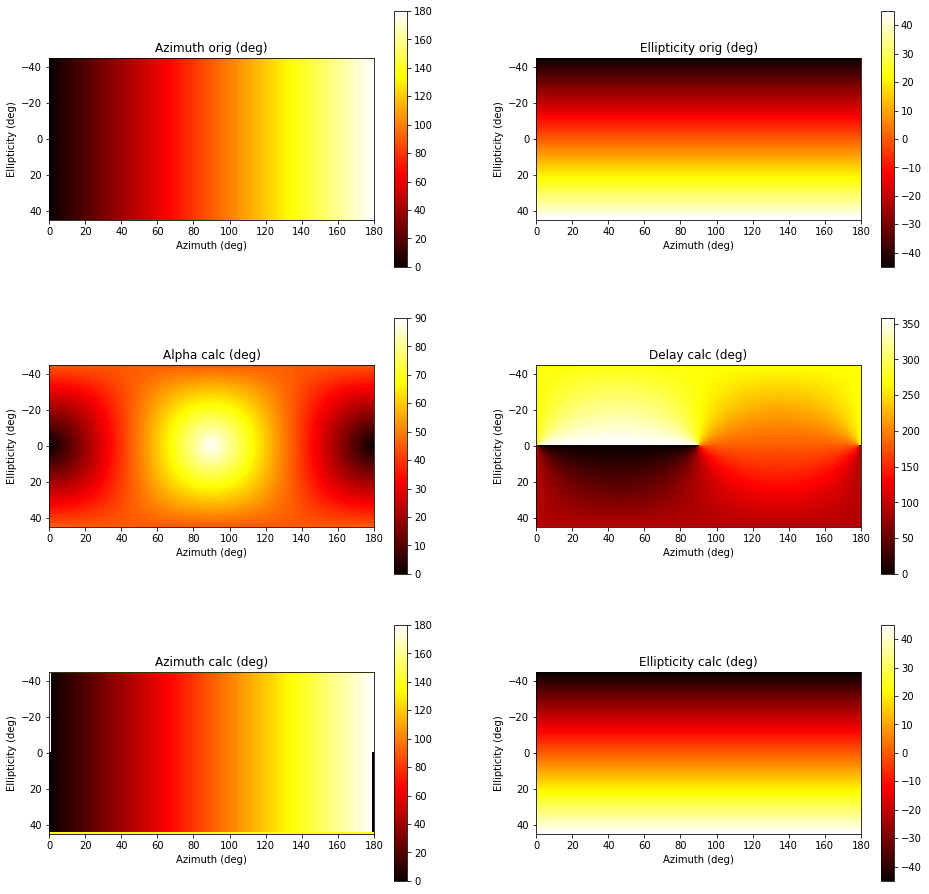

In [39]:
az = np.linspace(0, 180*degrees, 181)
el = np.linspace(-45*degrees, 45*degrees, 91)
Az, El = np.meshgrid(az, el)

Alpha, Delay = azimuth_elipt_2_charac_angles(Az, El)
Az2, El2 = charac_angles_2_azimuth_elipt(Alpha, Delay)

ext = [az[0]/degrees, az[-1]/degrees, el[-1]/degrees, el[0]/degrees]

plt.figure(figsize=(16,16))
plt.subplot(3,2,1)
plt.imshow(Az/degrees, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Azimuth orig (deg)')
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(El/degrees, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Ellipticity orig (deg)')
plt.colorbar()
plt.subplot(3,2,5)
plt.imshow(Az2/degrees, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Azimuth calc (deg)')
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(El2/degrees, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Ellipticity calc (deg)')
plt.colorbar()
plt.subplot(3,2,3)
plt.imshow(Alpha/degrees, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Alpha calc (deg)')
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(Delay/degrees, extent=ext, cmap='hot')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Ellipticity (deg)')
plt.title('Delay calc (deg)')
plt.colorbar()

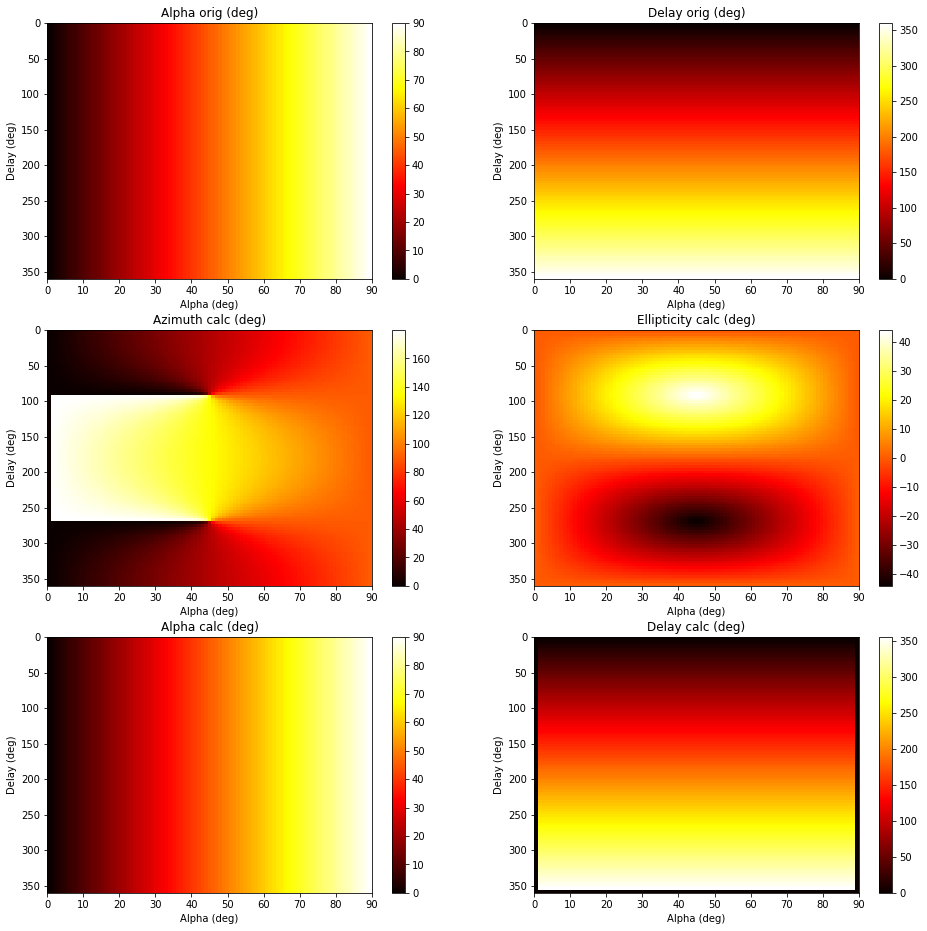

In [40]:
alpha = np.linspace(0, 90*degrees, 91)
delay = np.linspace(0, 360*degrees, 91)
Alpha, Delay = np.meshgrid(alpha, delay)

Az, El = charac_angles_2_azimuth_elipt(Alpha, Delay)
Alpha2, Delay2 = azimuth_elipt_2_charac_angles(Az, El)

ext = [alpha[0]/degrees, alpha[-1]/degrees, delay[-1]/degrees, delay[0]/degrees]

plt.figure(figsize=(16,16))
plt.subplot(3,2,1)
plt.imshow(Alpha/degrees, extent=ext, cmap='hot')
plt.xlabel('Alpha (deg)')
plt.ylabel('Delay (deg)')
plt.title('Alpha orig (deg)')
plt.colorbar()
plt.axis('auto')
plt.subplot(3,2,2)
plt.imshow(Delay/degrees, extent=ext, cmap='hot')
plt.xlabel('Alpha (deg)')
plt.ylabel('Delay (deg)')
plt.title('Delay orig (deg)')
plt.colorbar()
plt.axis('auto')
plt.subplot(3,2,3)
plt.imshow(Az/degrees, extent=ext, cmap='hot')
plt.xlabel('Alpha (deg)')
plt.ylabel('Delay (deg)')
plt.title('Azimuth calc (deg)')
plt.colorbar()
plt.axis('auto')
plt.subplot(3,2,4)
plt.imshow(El/degrees, extent=ext, cmap='hot')
plt.xlabel('Alpha (deg)')
plt.ylabel('Delay (deg)')
plt.title('Ellipticity calc (deg)')
plt.colorbar()
plt.axis('auto')
plt.subplot(3,2,5)
plt.imshow(Alpha2/degrees, extent=ext, cmap='hot')
plt.xlabel('Alpha (deg)')
plt.ylabel('Delay (deg)')
plt.title('Alpha calc (deg)')
plt.colorbar()
plt.axis('auto')
plt.subplot(3,2,6)
plt.imshow(Delay2/degrees, extent=ext, cmap='hot')
plt.xlabel('Alpha (deg)')
plt.ylabel('Delay (deg)')
plt.title('Delay calc (deg)')
plt.colorbar()
plt.axis('auto')

In [41]:
P2.diattenuator_perfect(azimuth=45*degrees)
Q2.quarter_waveplate()
E.general_charac_angles(alpha=45*degrees, delay=270*degrees)
print(P2 * Q2 * E)

J @ 45.00 deg * J * E = 
[+0.000-0.000j]   
[+0.000-0.000j]   



In [42]:
a1, d1 = PSA_angles_2_states(phi_P=np.array([90*degrees, 135*degrees]), phi_Q=np.array([135*degrees, 0]), output='charac')
print(a1/degrees, d1/degrees)

[45. 45.] [270. 270.]


In [46]:
angle_P1 = np.array([90, 90, 135, 135, 45, 45, 90, 90]) * degrees
angle_Q1 = np.array([90, 90, 90, 90, 45, 45, 60, 120]) * degrees
angle_P2 = np.array([90, 135, 0, 45, 45, 0, 90, 90]) * degrees
angle_Q2 = angle_P2


alpha_G2, delay_G2 = PSG_angles_2_states(angle_P1, angle_Q1, output='charac')
alpha_A2, delay_A2 = PSA_angles_2_states(angle_P2, angle_Q2, output='charac')

print(alpha_G2/degrees, delay_G2/degrees, alpha_A2/degrees, delay_A2/degrees, sep='\n')
for ind in range(8):
    print("{}: {:.0f}\t, {:.0f}\t, {:.0f}\t, {:.0f}\t".format(ind+1, alpha_G2[ind]/degrees, delay_G2[ind]/degrees, alpha_A2[ind]/degrees, delay_A2[ind]/degrees))

[90.         90.         45.         45.         45.         45.
 52.23875609 52.23875609]
[  0.           0.         270.         270.           0.
   0.         296.56505118 116.56505118]
[90. 45.  0. 45. 45.  0. 90. 90.]
[  0. 180.   0.   0.   0.   0.   0.   0.]
1: 90	, 0	, 90	, 0	
2: 90	, 0	, 45	, 180	
3: 45	, 270	, 0	, 0	
4: 45	, 270	, 45	, 0	
5: 45	, 0	, 45	, 0	
6: 45	, 0	, 0	, 0	
7: 52	, 297	, 90	, 0	
8: 52	, 117	, 90	, 0	


In [48]:
Az, El = charac_angles_2_azimuth_elipt(52*degrees, 117*degrees)
print(Az/degrees, El/degrees)

120.61237824497275 29.915100234933245
